# 0. Import Necessary Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [3]:
from sklearn.linear_model import LogisticRegression

In [4]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)

In [5]:
from sklearn.metrics import average_precision_score

In [6]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

In [7]:
from sklearn.metrics import f1_score,make_scorer
scored=make_scorer(f1_score)

# 1. Data I/O

In [8]:
data=pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 2. Data Exploration

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [10]:
data['Class'].value_counts() # Heavily Skewed

0    284315
1       492
Name: Class, dtype: int64

In [11]:
data['Class']=data['Class'].map({1:'Fraud',0:'Normal'})

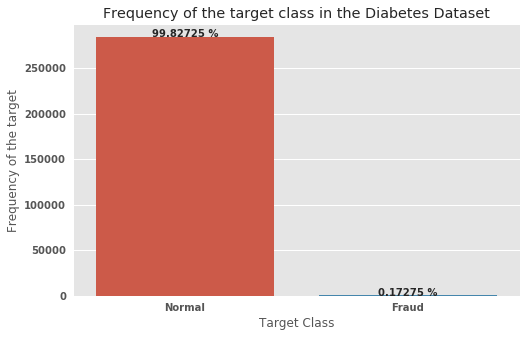

In [12]:
import matplotlib.style as style
style.use('ggplot')
plt.figure(figsize=(8,5))
ax=sns.countplot(x='Class', data=data);
total=float(len(data))
plt.title('Frequency of the target class in the Diabetes Dataset')
plt.ylabel('Frequency of the target')
plt.xlabel('Target Class')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.5f} %'.format(height*100/total),ha="center")

In [13]:
#sns.pairplot(data, hue="Outcome",diag_kind="kde")

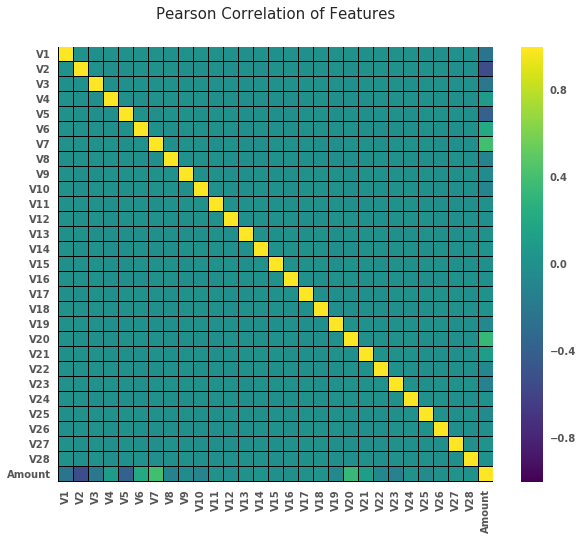

In [14]:
data_num=data.drop(['Time','Class'],axis=1)
colormap = plt.cm.viridis
plt.figure(figsize=(10,8))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data_num.astype(float).corr(),linewidths=0.05,vmax=1.0, square=True, cmap=colormap, linecolor='black', annot=False);

# 3. Data preprocessing

In [15]:
X=data.drop(['Time','Class'],axis=1)
Y=data[['Class']]
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=0,stratify=Y.Class)

In [16]:
X_train['Amount']=StandardScaler().fit_transform(X_train['Amount'].values.reshape(-1, 1))
X_test['Amount']=StandardScaler().fit_transform(X_test['Amount'].values.reshape(-1, 1))

In [17]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
159810,-0.213791,0.827086,0.476312,0.324509,0.682825,0.738069,0.635548,0.020445,0.601290,-0.392651,...,-0.224666,-0.452713,-1.168484,0.154762,-0.039586,-0.434352,-1.206826,-0.299128,0.035932,-0.212896
78456,1.108114,0.076161,0.180980,0.747022,-0.422557,-1.096108,0.327595,-0.144312,-0.023643,-0.063789,...,-0.159342,-0.306208,-1.060680,0.214553,0.549775,0.097760,0.029681,-0.057002,0.017881,-0.140177
159663,0.054750,0.929015,0.253177,-0.628441,0.568255,-1.024227,1.064345,-0.249808,-0.173203,-0.436210,...,0.023266,-0.260095,-0.523044,0.037893,-0.091845,-0.438712,0.144389,0.253354,0.097885,-0.339036
6517,-0.318601,1.130156,1.761166,1.423952,0.225281,-0.320472,0.509444,-0.114489,0.477863,-0.527181,...,0.001433,0.100244,0.640482,-0.116636,0.363731,-0.315616,-0.248976,0.162759,0.150523,-0.320288
11579,1.410336,-0.625361,0.289247,-0.541446,-0.717432,-0.018733,-0.871735,0.040156,0.880404,0.337488,...,-0.062141,-0.192763,-0.324472,-0.117071,-0.574782,0.560330,-0.243539,-0.028145,-0.015180,-0.306834


In [18]:
X_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
175371,-0.333572,-0.260711,-0.444573,-1.269694,-0.722845,1.026726,1.714035,-0.224337,-1.230857,0.171356,...,-0.495949,-0.136521,0.299618,0.194141,0.229860,-0.661863,0.261762,0.207698,0.137946,1.005159
240914,1.919125,-0.483016,-0.175210,0.443473,-0.841282,-0.355453,-0.712288,0.090086,1.242635,0.009596,...,-0.224362,0.250701,0.925525,0.118774,0.095816,-0.149623,-0.237904,0.035786,-0.045510,-0.317212
274643,0.036437,1.363662,-1.193580,0.105581,0.353584,-1.153817,0.544680,0.178014,-0.104319,-0.516363,...,-0.080112,-0.064618,-0.087809,0.566757,1.059573,-2.270369,-0.078836,0.330675,0.393533,-0.359232
242546,2.056321,-1.829648,-0.732793,-1.353940,-1.765126,-0.863630,-1.139042,-0.204751,-0.924425,1.523665,...,-0.249274,-0.086128,-0.013440,0.159245,-0.059305,-0.344454,-0.184234,-0.000413,-0.026384,0.181869
253876,0.086220,0.625644,1.838501,1.073470,-0.306243,0.022964,0.266889,-0.250856,0.119789,-0.003614,...,0.379927,0.316322,1.399831,-0.355504,0.137635,-0.239085,0.285450,0.070170,-0.059021,-0.308825


In [19]:
# mapping back
Y_train['Class']=Y_train['Class'].map({'Fraud':1,'Normal':0})
Y_test['Class']=Y_test['Class'].map({'Fraud':1,'Normal':0})

In [20]:
#Y_train.values

In [21]:
# already Principal components
X_train_pca=X_train[['V1','V2','V3','V4','V5']]

In [22]:
X_train_pca['Class']=Y_train

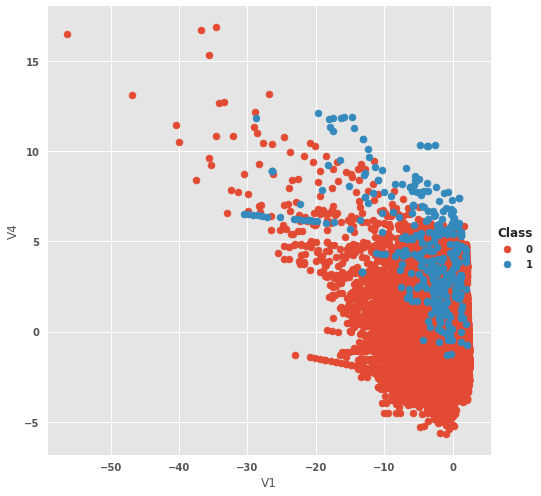

In [23]:
sns.FacetGrid(X_train_pca, hue="Class", size=7).map(plt.scatter, "V1", "V4").add_legend()

# 4. Utility Functions

In [24]:
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}
axis_font = {'fontname':'Arial', 'size':'16'}

In [25]:
def data_prep(df):
    X=data.drop(['Time','Class'],axis=1)
    Y=data[['Class']]
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=0,stratify=Y.Class)
    
    X_train.reset_index(inplace=True)
    X_train.drop('index',axis=1,inplace=True)
    Y_train.reset_index(inplace=True)
    Y_train.drop('index',axis=1,inplace=True)
    X_test.reset_index(inplace=True)
    X_test.drop('index',axis=1,inplace=True)
    Y_test.reset_index(inplace=True)
    Y_test.drop('index',axis=1,inplace=True)
    
    X_train['Amount']=StandardScaler().fit_transform(X_train['Amount'].values.reshape(-1, 1))
    X_test['Amount']=StandardScaler().fit_transform(X_test['Amount'].values.reshape(-1, 1))
    
    # mapping back
    Y_train['Class']=Y_train['Class'].map({'Fraud':1.0,'Normal':0.0})
    Y_test['Class']=Y_test['Class'].map({'Fraud':1.0,'Normal':0.0})
    
    return(X_train,Y_train,X_test,Y_test)

In [26]:
import itertools

def plot_confusion_matrix(axd,cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.sca(axd)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        1#print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",size=16)
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
def model_fitting_and_post_processing(clf,X_train,Y_train,X_test,Y_test,clf_name='SVM',class_names=[0,1],cross_val=False):
    #average precision for the precision recall curves
    # passing dataframes into the function
    clf.fit(X_train.values,Y_train.values.ravel())
    #print(clf.best_estimator_)
    if cross_val:
        clf=clf.best_estimator_
        print('\n')
        print(clf)
        print('\n')
    predictions=clf.predict(X_test.values)
    #decision function
    try:
        Y_score = clf.decision_function(X_test.values)
    except:
        Y_score = clf.predict_proba(X_test.values)[:,1]
    #Y_score=clf.decision_function(X_test.values)
    # printing the accuracy
    print('The accruacy of %s on the Test set: '%clf_name, accuracy_score(Y_test.values,predictions))
    # predicting probabilities
    post_probab_predictions=clf.predict_proba(X_test.values)
    # assiging the probability
    post_probab_predictions=post_probab_predictions[:,1]
    # now subplotting
    fig, axes=plt.subplots(2,2,figsize=(14,10))
    # Class Distribution
    plt.sca(axes[0,0])
    data_train=X_train.copy()
    data_train['Class']=Y_train.values
    data_train['Class']=data_train['Class'].map({1.0:'Fraud',0.0:'Normal'})
    ax=sns.countplot(x='Class', data=data_train);
    total=float(len(data_train))
    plt.title('Frequency of the target class in the Training-set',**title_font)
    plt.ylabel('Frequency of the target',**axis_font)
    plt.xlabel('Target Class',**axis_font)

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.5f} %'.format(height*100/total),ha="center")
        #ax.text(p.get_x()+p.get_width()/2.,height - 35,'{:1.5f} '.format(height),ha="center")
    
    # Confusion Matrix
    cnf_matrix = confusion_matrix(Y_test.values,predictions)
    np.set_printoptions(precision=2)
    plot_confusion_matrix(axes[0,1],cnf_matrix, classes=class_names, title='Confusion matrix')
    axes[0,1].grid('off')

    # ROC CURVE
    fpr, tpr, thresholds = roc_curve(Y_test.values.ravel(),post_probab_predictions.ravel())
    roc_auc = auc(fpr,tpr)
    plt.style.use('ggplot')
    title_gp='ROC for '+clf_name+' Classifier'
    axes[1,0].set_title(title_gp)
    axes[1,0].plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
    axes[1,0].legend(loc='lower right')
    axes[1,0].plot([0,1],[0,1],'r--')
    axes[1,0].set_ylabel('True Positive Rate',**axis_font)
    axes[1,0].set_xlabel('False Positive Rate',**axis_font)
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(Y_test.values.ravel(), Y_score)
    average_precision = average_precision_score(Y_test.values.ravel(), Y_score)
    axes[1,1].step(recall, precision, color='red', alpha=0.2,where='post',label='Average Precision = %0.2f'%average_precision)
    axes[1,1].fill_between(recall, precision, step='post', alpha=0.2,color='b')
    axes[1,1].legend(loc='lower right')
    axes[1,1].set_xlabel('Recall',**axis_font)
    axes[1,1].set_ylabel('Precision',**axis_font)
    title_gp='Precision-Recall Curve for '+clf_name+' Classifier'
    axes[1,1].set_title(title_gp)


    fig.tight_layout()
    print('\n')
    print('----------------------- Complete Classification Report -----------------------\n')
    print(classification_report(Y_test.values,predictions))
    print('\n')
    print('--------------------------- Post-processed Plots --------------------------\n')    
    return (predictions,post_probab_predictions)

In [326]:
def feature_engineering(data):
    X=data.drop(['Time','Class'],axis=1)
    Y=data[['Class']]
    
    #Drop all of the features that have very similar distributions between the two types of transactions.
    X = X.drop(['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8'], axis =1)
    
    #Based on the plots above, these features are created to identify values where fraudulent transaction are more common.
    X['V1_'] = X.V1.map(lambda x: 1 if x < -3 else 0)
    X['V2_'] = X.V2.map(lambda x: 1 if x > 2.5 else 0)
    X['V3_'] = X.V3.map(lambda x: 1 if x < -4 else 0)
    X['V4_'] = X.V4.map(lambda x: 1 if x > 2.5 else 0)
    X['V5_'] = X.V5.map(lambda x: 1 if x < -4.5 else 0)
    X['V6_'] = X.V6.map(lambda x: 1 if x < -2.5 else 0)
    X['V7_'] = X.V7.map(lambda x: 1 if x < -3 else 0)
    X['V9_'] = X.V9.map(lambda x: 1 if x < -2 else 0)
    X['V10_'] = X.V10.map(lambda x: 1 if x < -2.5 else 0)
    X['V11_'] = X.V11.map(lambda x: 1 if x > 2 else 0)
    X['V12_'] = X.V12.map(lambda x: 1 if x < -2 else 0)
    X['V14_'] = X.V14.map(lambda x: 1 if x < -2.5 else 0)
    X['V16_'] = X.V16.map(lambda x: 1 if x < -2 else 0)
    X['V17_'] = X.V17.map(lambda x: 1 if x < -2 else 0)
    X['V18_'] = X.V18.map(lambda x: 1 if x < -2 else 0)
    X['V19_'] = X.V19.map(lambda x: 1 if x > 1.5 else 0)
    X['V21_'] = X.V21.map(lambda x: 1 if x > 0.6 else 0)
    X['Amount_max_fraud'] = 1
    X.loc[X.Amount <= 2125.87, 'Amount_max_fraud'] = 0
    
    X_feat_train,X_feat_test,Y_feat_train,Y_feat_test = train_test_split(X,Y,test_size=0.3,random_state=0,stratify=Y.Class)
    
    X_feat_train.reset_index(inplace=True)
    X_feat_train.drop('index',axis=1,inplace=True)
    Y_feat_train.reset_index(inplace=True)
    Y_feat_train.drop('index',axis=1,inplace=True)
    X_feat_test.reset_index(inplace=True)
    X_feat_test.drop('index',axis=1,inplace=True)
    Y_feat_test.reset_index(inplace=True)
    Y_feat_test.drop('index',axis=1,inplace=True)
    
    X_feat_train['Amount']=StandardScaler().fit_transform(X_feat_train['Amount'].values.reshape(-1,1))
    X_feat_test['Amount']=StandardScaler().fit_transform(X_feat_test['Amount'].values.reshape(-1,1))
    
    Y_feat_train['Class']=Y_feat_train['Class'].map({'Fraud':1.0,'Normal':0.0})
    Y_feat_test['Class']=Y_feat_test['Class'].map({'Fraud':1.0,'Normal':0.0})
    return(X_feat_train,Y_feat_train,X_feat_test,Y_feat_test)

In [29]:
def sample_prep(data):
    X_rtrain=data_resampled.drop(['Class'],axis=1)
    Y_rtrain=data_resampled[['Class']]
    xcols=X_rtrain.columns.tolist()
    X_rtrain=StandardScaler().fit_transform(X_rtrain)
    X_rtrain=pd.DataFrame(X_rtrain,columns=xcols)
    
    return (X_rtrain,Y_rtrain)

In [200]:
X_train,Y_train,X_test,Y_test=data_prep(data)

os_ada=ADASYN(random_state=0)
xcols=X_train.columns.tolist()
X_oversampled,Y_oversampled=os_ada.fit_sample(X_train,Y_train.values.ravel())
data_resampled=pd.DataFrame(X_oversampled,columns=xcols)
data_resampled['Class']=Y_oversampled

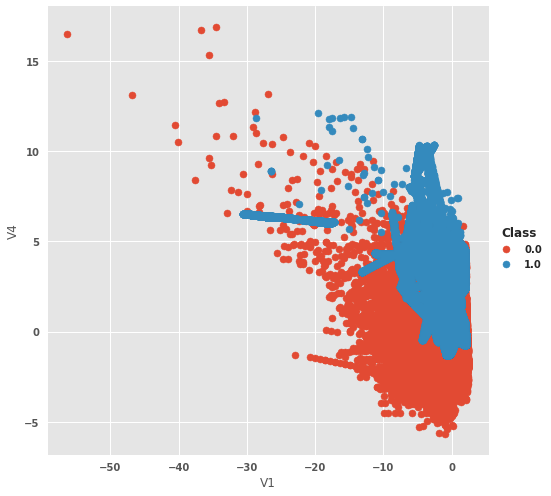

In [201]:
sns.FacetGrid(data_resampled, hue="Class", size=7).map(plt.scatter, "V1", "V4").add_legend()

# 5. Model Building

## 5.1 Logisitic regression (benchmark)

In [ ]:
clf_log=LogisticRegression()
X_train,Y_train,X_test,Y_test=data_prep(data)
pred_log1,pred_probab1=model_fitting_and_post_processing(clf_log,X_train,Y_train,X_test,Y_test,clf_name='Logistic Reg',class_names=['Normal','Fraud'])

## 5.2 Logisitic regression with ADASYN (benchmark)

In [31]:
X_train,Y_train,X_test,Y_test=data_prep(data)

os_ada=ADASYN(random_state=0)
xcols=X_train.columns.tolist()
X_oversampled,Y_oversampled=os_ada.fit_sample(X_train,Y_train.values.ravel())
data_resampled=pd.DataFrame(X_oversampled,columns=xcols)
data_resampled['Class']=Y_oversampled
X_rtrain,Y_rtrain=sample_prep(data_resampled)

The accruacy of Logistic Reg + ADASYN on the Test set:  0.145254731224325


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      0.14      0.25     85295
        1.0       0.00      0.99      0.00       148

avg / total       1.00      0.15      0.25     85443



--------------------------- Post-processed Plots --------------------------



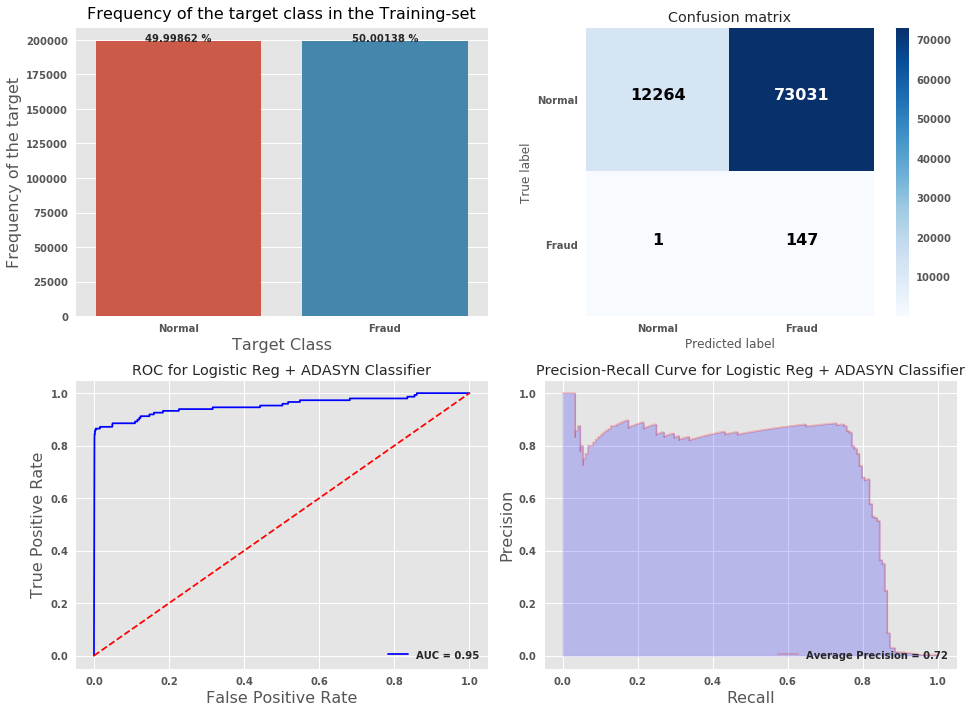

In [32]:
pred_log2,pred_probab2=model_fitting_and_post_processing(clf_log,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='Logistic Reg + ADASYN',class_names=['Normal','Fraud'])

## 5.3 Logisitic regression with Under Sampling(benchmark)

In [43]:
X_train,Y_train,X_test,Y_test=data_prep(data)
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
xcols=X_train.columns.tolist()
X_undersampled,Y_undersampled=rus.fit_sample(X_train,Y_train.values.ravel())
data_resampled=pd.DataFrame(X_undersampled,columns=xcols)
data_resampled['Class']=Y_undersampled
X_utrain,Y_utrain=sample_prep(data_resampled)

The accruacy of Logistic Reg + Rand Under on the Test set:  0.20411268330934074


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      0.20      0.34     85295
        1.0       0.00      1.00      0.00       148

avg / total       1.00      0.20      0.34     85443



--------------------------- Post-processed Plots --------------------------



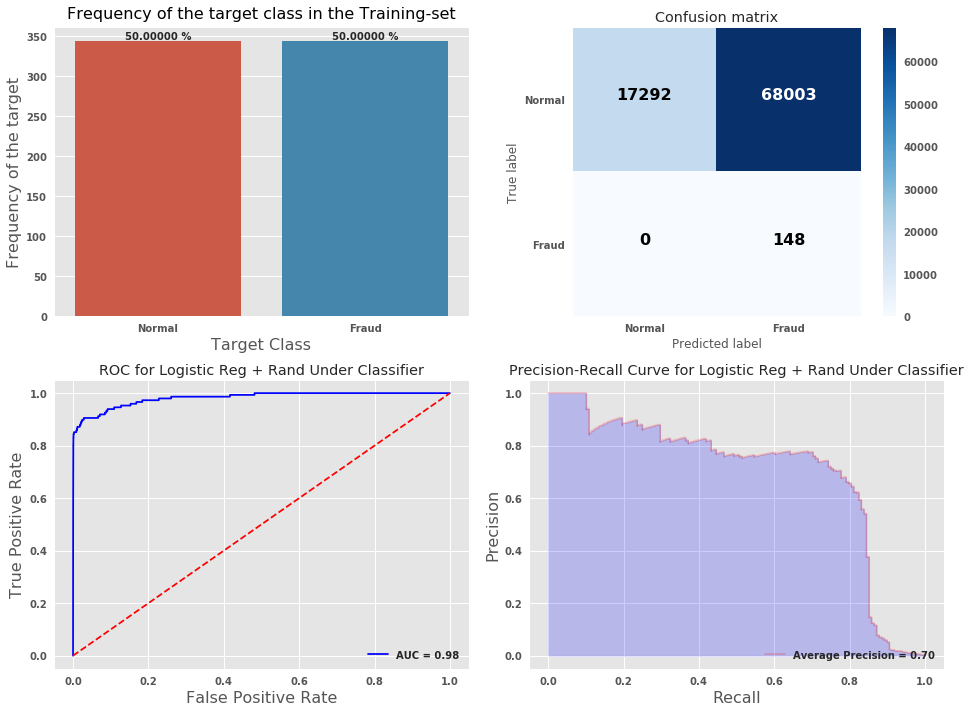

In [46]:
pred_log3,pred_probab3=model_fitting_and_post_processing(clf_log,X_utrain,Y_utrain,X_test,Y_test,clf_name='Logistic Reg + Rand Under',class_names=['Normal','Fraud'])

In [33]:
#X_utrain,Y_utrain=sample_prep(data_resampled)

## 5.4 Random Forests + No CV

The accruacy of Random Forests on the Test set:  0.9994850368081645


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     85295
        1.0       0.96      0.73      0.83       148

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



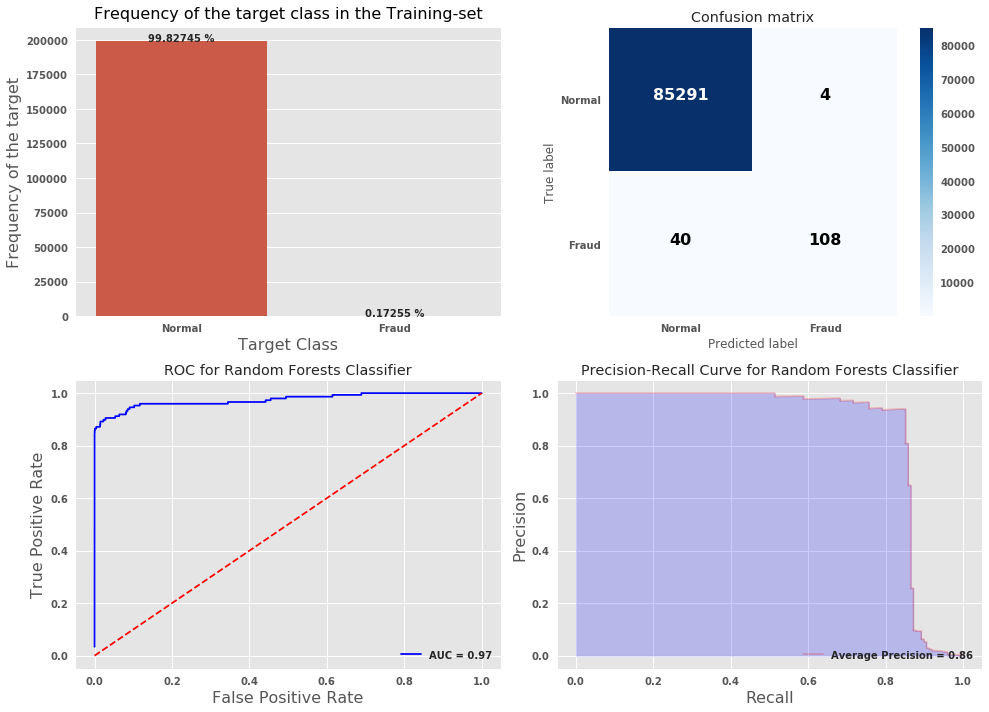

In [34]:
clf_rf=RandomForestClassifier(n_estimators=200,max_depth=10,n_jobs=8,random_state=0)
X_train,Y_train,X_test,Y_test=data_prep(data)
preds_rf1,probab_rf1=model_fitting_and_post_processing(clf_rf,X_train,Y_train,X_test,Y_test,clf_name='Random Forests',class_names=['Normal','Fraud'])

## 5.5 Random Forests + No CV + ADASYN

The accruacy of Random Forests + ADASYN on the Test set:  0.977095841672226


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      0.98      0.99     85295
        1.0       0.06      0.86      0.11       148

avg / total       1.00      0.98      0.99     85443



--------------------------- Post-processed Plots --------------------------



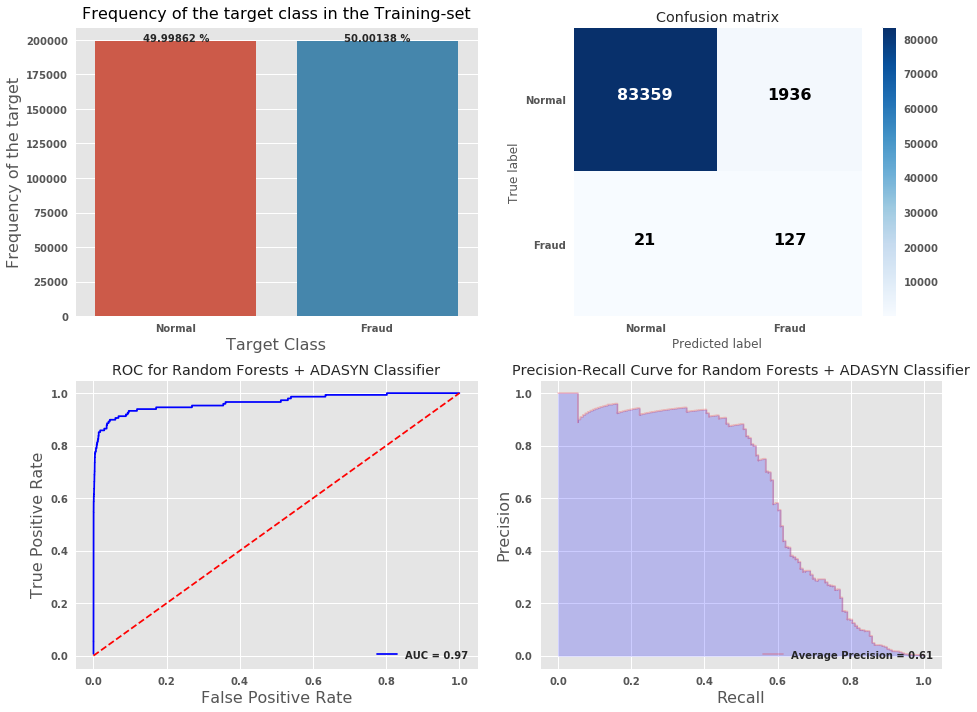

In [35]:
preds_rf2,probab_rf2=model_fitting_and_post_processing(clf_rf,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='Random Forests + ADASYN',class_names=['Normal','Fraud'])

## 5.6 Random Forests + No CV + Random Under Sampling

The accruacy of Random Forests + Rand under sampling on the Test set:  0.05190594899523659


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      0.05      0.10     85295
        1.0       0.00      1.00      0.00       148

avg / total       1.00      0.05      0.10     85443



--------------------------- Post-processed Plots --------------------------



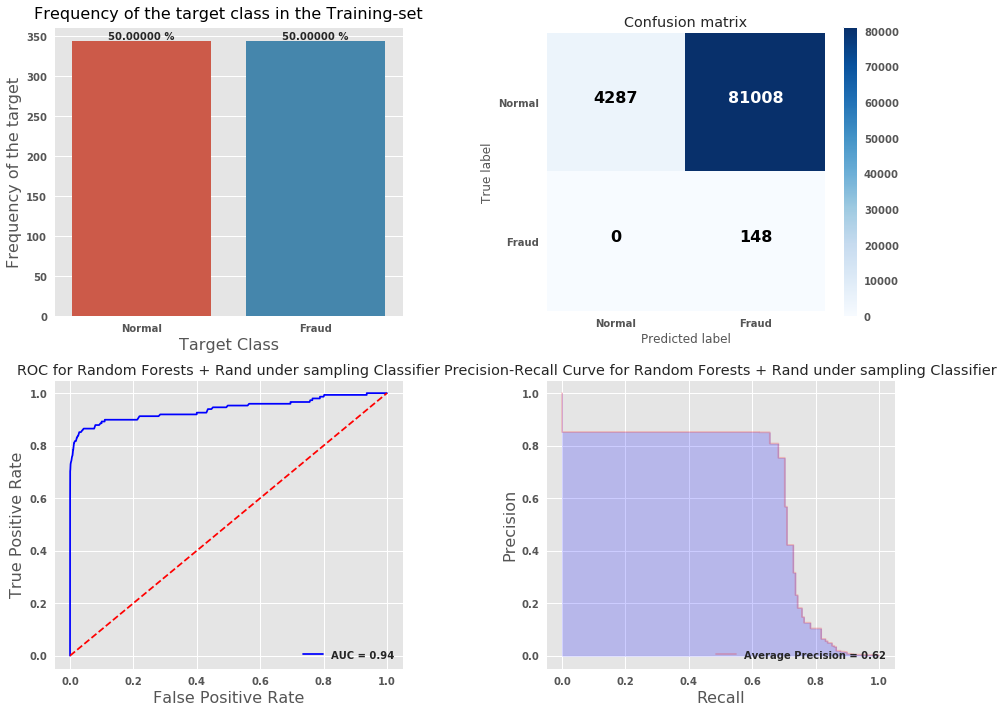

In [48]:
clf_rf=RandomForestClassifier(n_estimators=200,max_depth=10,n_jobs=8,random_state=0)
preds_rf3,probab_rf3=model_fitting_and_post_processing(clf_rf,X_utrain,Y_utrain,X_test,Y_test,clf_name='Random Forests + Rand under sampling',class_names=['Normal','Fraud'])

## 5.7 Random Forests + Stra. KFold + ADASYN

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 16.4min
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed: 38.9min finished




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=188, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


The accruacy of Random Forests with CV + ADASYN on the Test set:  0.8064908769589083


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      0.81      0.89     85295
        1.0       0.01      0.95      0.02       148

avg / total       1.00      0.81      0.89     85443



--------------------------- Post-processed Plots --------------------------



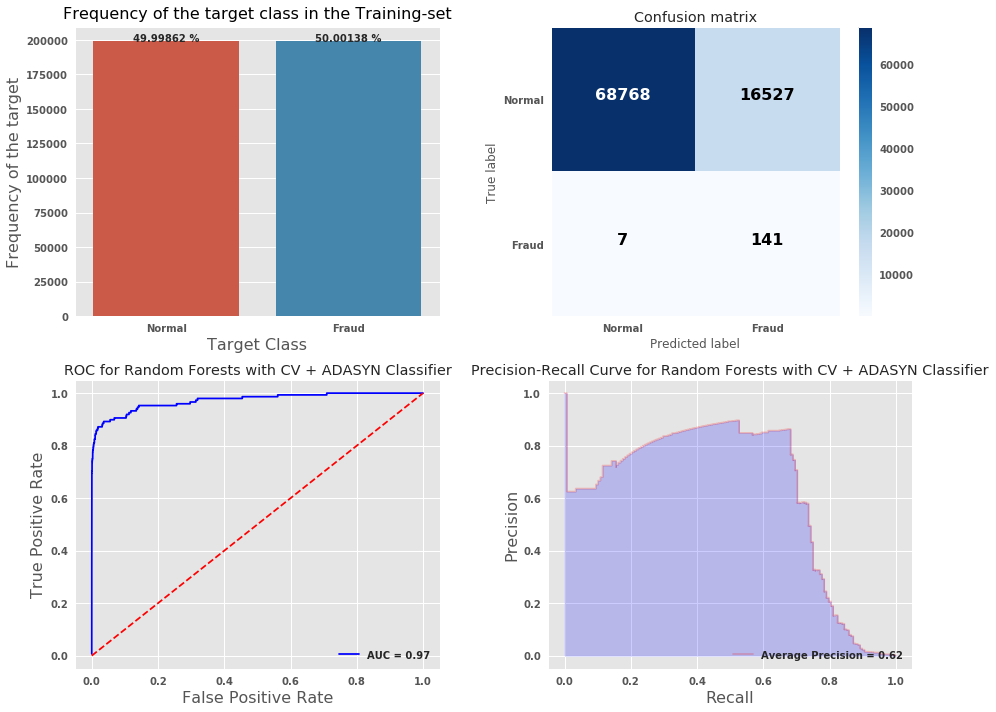

In [51]:
clf_rf=RandomForestClassifier(random_state=0)
params_rf = {"n_estimators": st.randint(100, 500),"max_depth": st.randint(4, 6),'min_samples_split':st.randint(2,6)}
rfrscv=RandomizedSearchCV(clf_rf, param_distributions=params_rf,n_iter=15,n_jobs=8,scoring=scored,cv=skf,verbose=True,random_state=0)
rf_preds4,probab_rf4=model_fitting_and_post_processing(rfrscv,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='Random Forests with CV + ADASYN',class_names=['Normal','Fraud'],cross_val=True)

## 5.8 Random Forests + Stra. KFold + Rand Under Sampling

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed:    5.6s finished




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=342, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


The accruacy of Random Forests with CV + RUS on the Test set:  0.07344077338108447


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      0.07      0.13     85295
        1.0       0.00      1.00      0.00       148

avg / total       1.00      0.07      0.13     85443



--------------------------- Post-processed Plots --------------------------



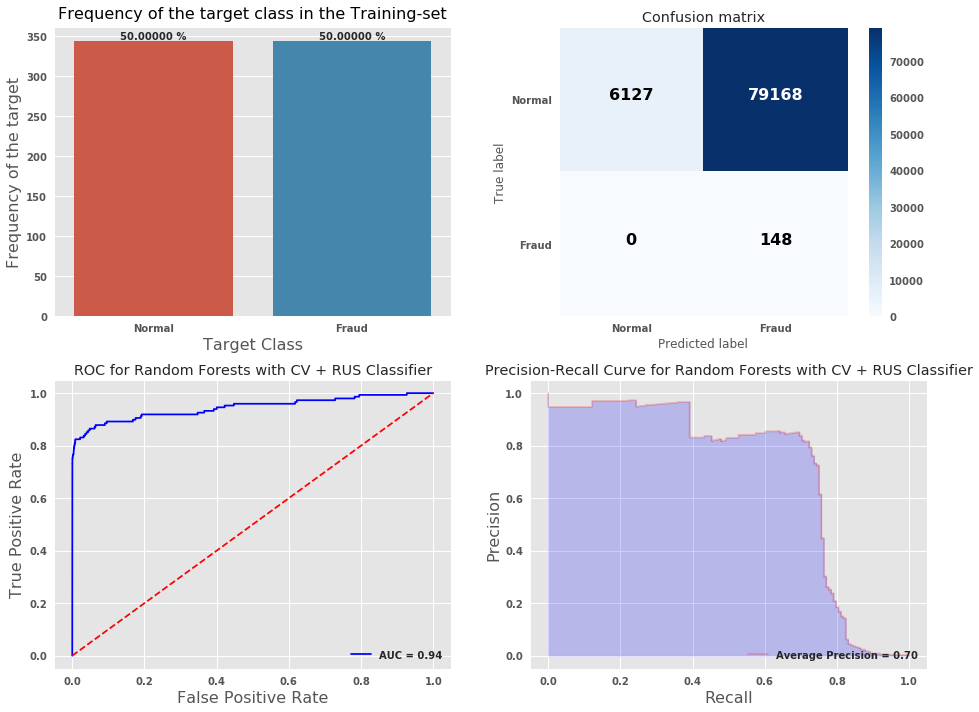

In [50]:
rf_preds4,probab_rf4=model_fitting_and_post_processing(rfrscv,X_utrain,Y_utrain,X_test,Y_test,clf_name='Random Forests with CV + RUS',class_names=['Normal','Fraud'],cross_val=True)

## 5.9 Random Forests + Stra. KFold + Feat.

In [39]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=5,random_state=0)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  4.7min
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed: 11.4min finished




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=342, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


The accruacy of Random Forests with CV on the Test set:  0.9993914071369217


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     85295
        1.0       0.89      0.74      0.81       148

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



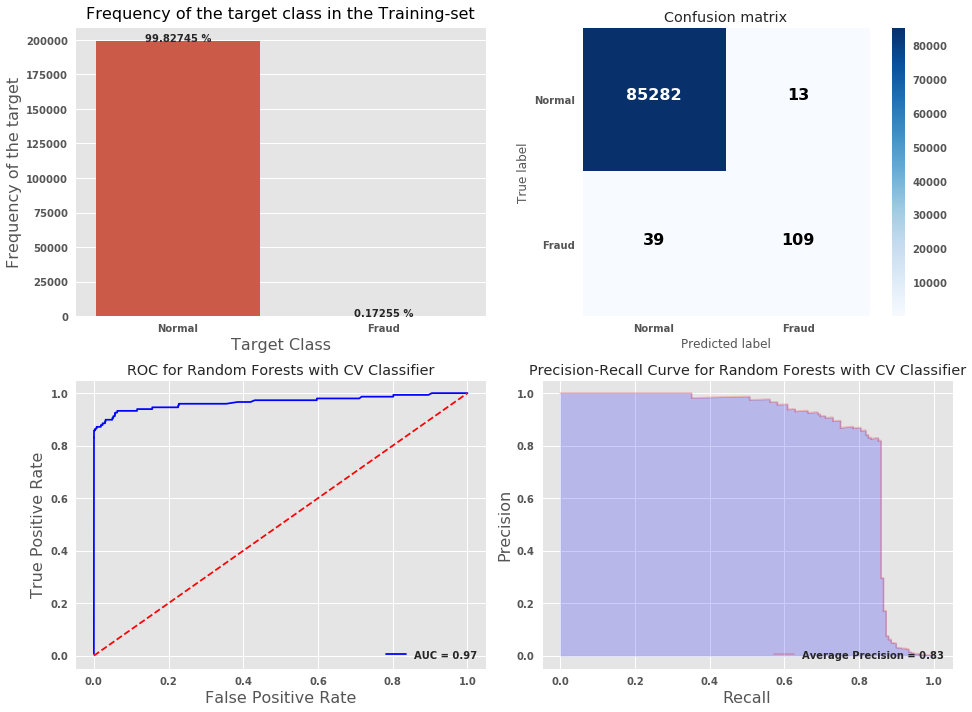

In [40]:
clf_rf=RandomForestClassifier(random_state=0)
params_rf = {"n_estimators": st.randint(100, 500),"max_depth": st.randint(4, 6),'min_samples_split':st.randint(2,6)}
X_train,Y_train,X_test,Y_test=feature_engineering(data)
rfrscv=RandomizedSearchCV(clf_rf, param_distributions=params_rf,n_iter=15,n_jobs=8,scoring=scored,cv=skf,verbose=True,random_state=0)
rf_preds6,probab_rf6=model_fitting_and_post_processing(rfrscv,X_train,Y_train,X_test,Y_test,clf_name='Random Forests with CV',class_names=['Normal','Fraud'],cross_val=True)

## 5.10 XGBoost + No CV

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The accruacy of XGBoost on the Test set:  0.9995435553526912


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     85295
        1.0       0.96      0.77      0.85       148

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



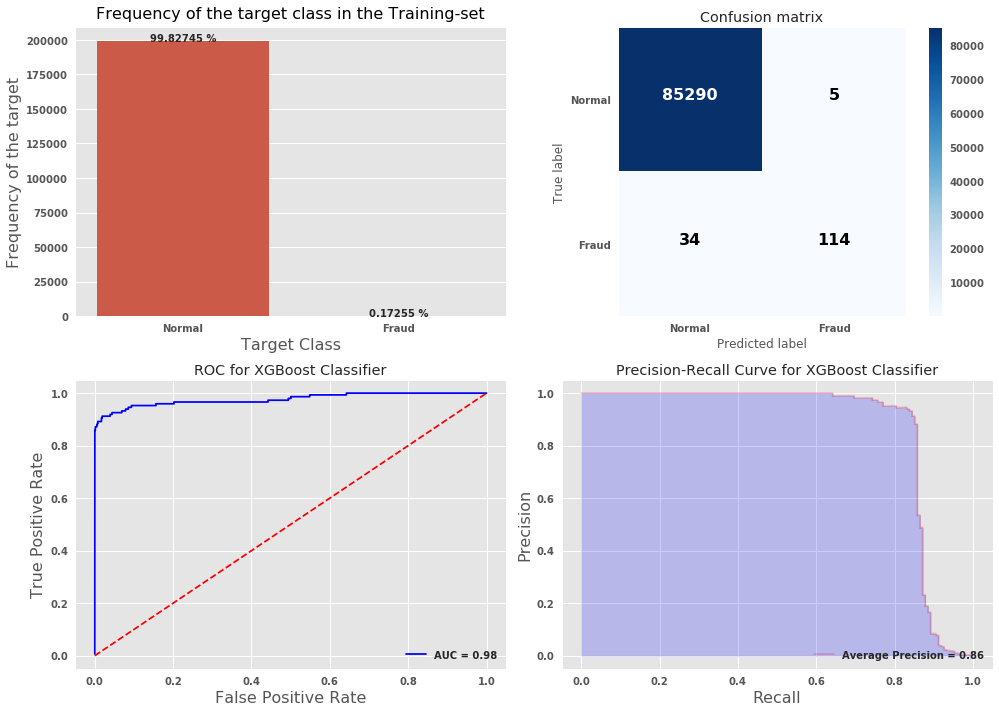

In [56]:
clf_xgbc=xgb.XGBClassifier(n_estimators=200,max_depth=5,random_state=0,n_jobs=-1)
X_train,Y_train,X_test,Y_test=data_prep(data)
xgb_preds1,xgb_probab1=model_fitting_and_post_processing(clf_xgbc,X_train,Y_train,X_test,Y_test,clf_name='XGBoost',class_names=['Normal','Fraud'])

## 5.11 XGBoost + No CV + ADASYN

In [62]:
X_train,Y_train,X_test,Y_test=data_prep(data)
xcols=X_train.columns.tolist()
X_oversampled,Y_oversampled=os_ada.fit_sample(X_train,Y_train.values.ravel())
data_resampled=pd.DataFrame(X_oversampled,columns=xcols)
data_resampled['Class']=Y_oversampled
X_rtrain,Y_rtrain=sample_prep(data_resampled)

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The accruacy of XGBoost with ADASYN on the Test set:  0.9753168779186124


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      0.98      0.99     85295
        1.0       0.06      0.83      0.10       148

avg / total       1.00      0.98      0.99     85443



--------------------------- Post-processed Plots --------------------------



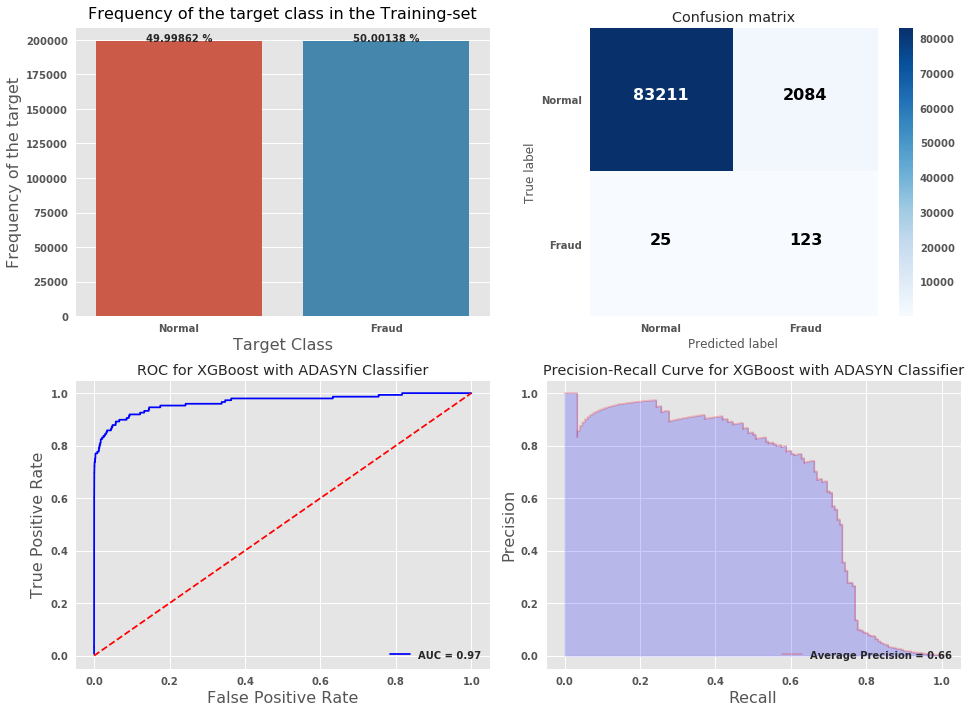

In [63]:
xgb_pred2,xgb_probab2=model_fitting_and_post_processing(clf_xgbc,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='XGBoost with ADASYN',class_names=['Normal','Fraud'])

## 5.12 XGBoost + No CV + Rand Under sampling

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed:    5.7s finished




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=342, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


The accruacy of XGBoost with CV + RUS on the Test set:  0.07344077338108447


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      0.07      0.13     85295
        1.0       0.00      1.00      0.00       148

avg / total       1.00      0.07      0.13     85443



--------------------------- Post-processed Plots --------------------------



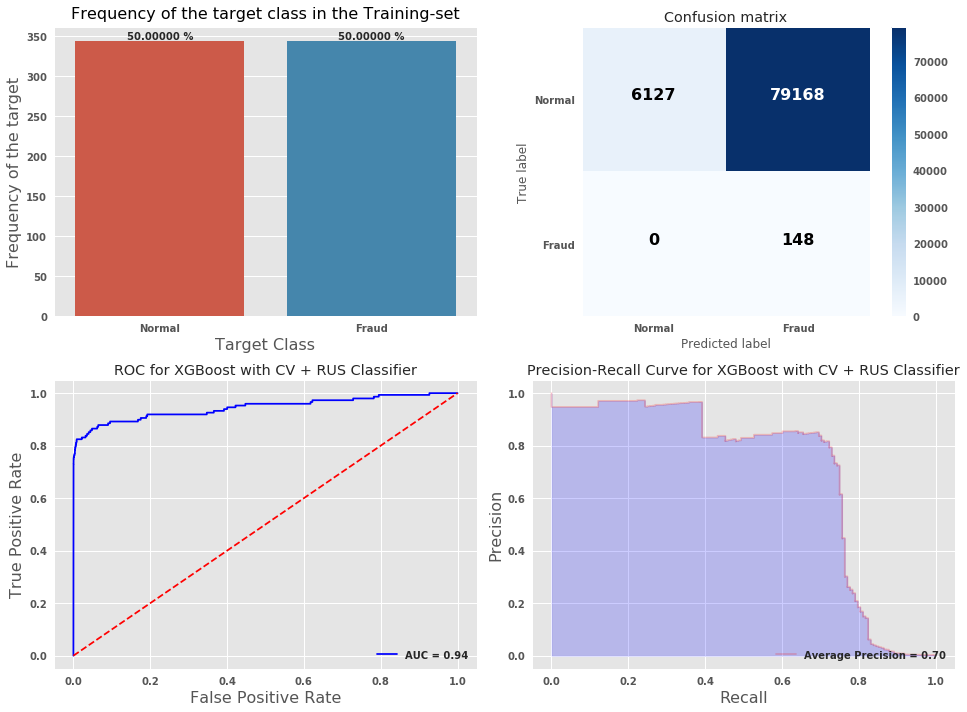

In [65]:
xgb_preds4,xgb_probab4=model_fitting_and_post_processing(rfrscv,X_utrain,Y_utrain,X_test,Y_test,clf_name='XGBoost with CV + RUS',class_names=['Normal','Fraud'],cross_val=True)

## 5.13 XGBoost + Stra. KFold + ADASYN

In [66]:
clf_xgb=xgb.XGBClassifier(random_state=0)
params_xgb={'learning_rate':st.uniform(0.01,0.1), 'n_estimators':st.randint(200,500), 'subsample':[0.8,0.9], 'colsample_bytree':[0.8,0.9], 'max_depth' :st.randint(6,10)}

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.10500469874014907,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=436, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)




/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The accruacy of XGBoost with CV + ADASYN on the Test set:  0.9846564376250834


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      0.98      0.99     85295
        1.0       0.09      0.82      0.16       148

avg / total       1.00      0.98      0.99     85443



--------------------------- Post-processed Plots --------------------------



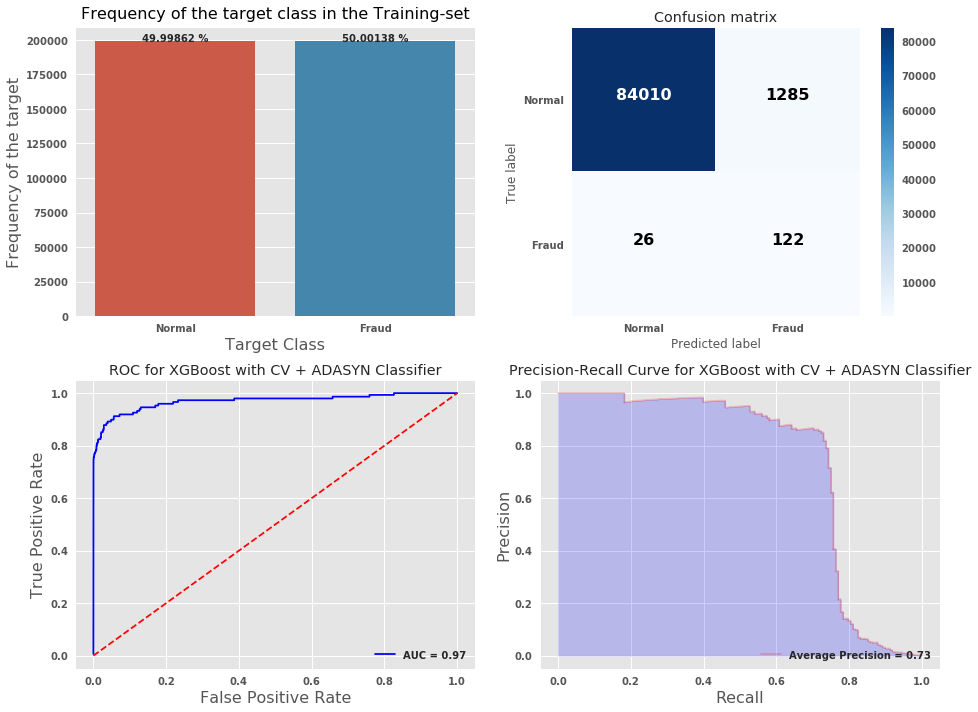

In [67]:
xgbrscv=RandomizedSearchCV(clf_xgb, param_distributions=params_xgb,n_iter=15,n_jobs=8,scoring=scored,cv=skf,verbose=True,random_state=0)
xgb_pred4,xgb_probab4=model_fitting_and_post_processing(xgbrscv,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='XGBoost with CV + ADASYN',class_names=['Normal','Fraud'],cross_val=True)

## 5.14 XGBoost + Stra. KFold + Rand Under Sampling

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.07540089548675852,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=423, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)




/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The accruacy of XGBoost with CV + RUS on the Test set:  0.19506571632550354


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      0.19      0.32     85295
        1.0       0.00      0.99      0.00       148

avg / total       1.00      0.20      0.32     85443



--------------------------- Post-processed Plots --------------------------



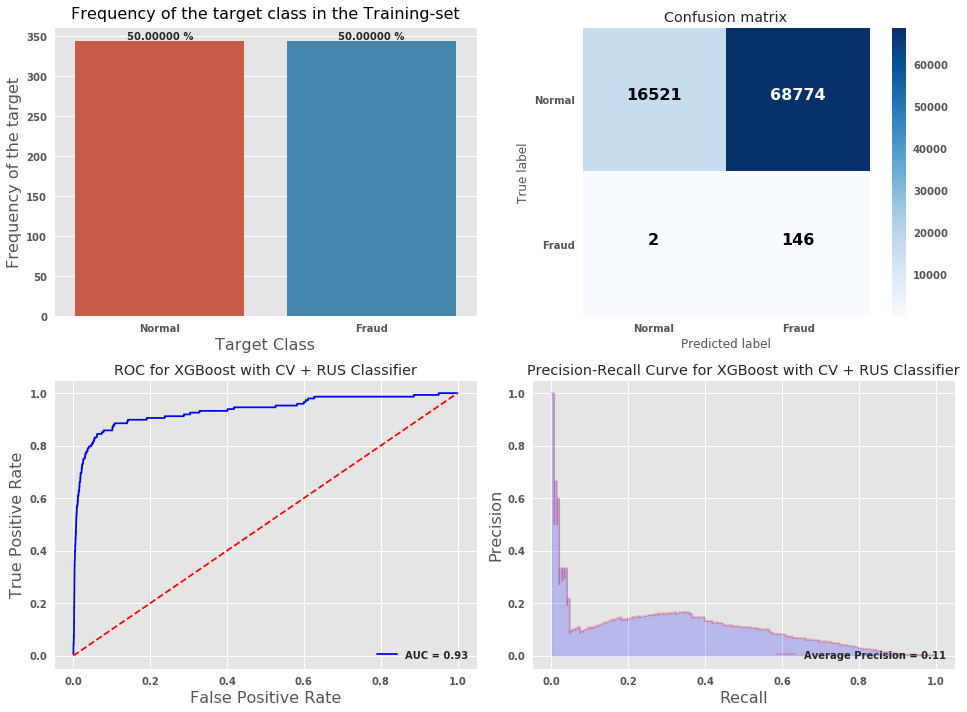

In [68]:
xgb_pred5,xgb_probab5=model_fitting_and_post_processing(xgbrscv,X_utrain,Y_utrain,X_test,Y_test,clf_name='XGBoost with CV + RUS',class_names=['Normal','Fraud'],cross_val=True)

## 5.15 XGBoost+ Stra. KFold + Feat.

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.03975346065444723,
       max_delta_step=0, max_depth=14, min_child_weight=1, missing=None,
       n_estimators=188, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)




/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The accruacy of XGBoost with CV on the Test set:  0.9995201479348805


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     85295
        1.0       0.95      0.76      0.85       148

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



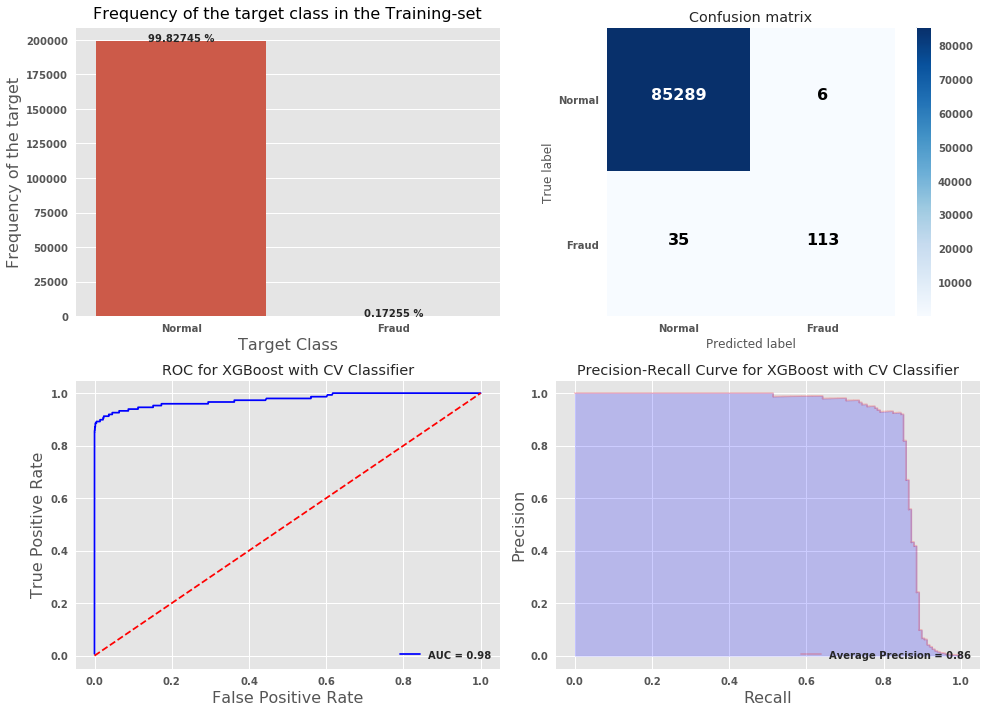

In [70]:
clf_xgb=xgb.XGBClassifier(random_state=0)
params_xgb={'learning_rate':st.uniform(0.01,0.1), 'n_estimators':st.randint(100,300), 'subsample':[0.8,0.9], 'colsample_bytree':[0.8,0.9], 'max_depth' :st.randint(6,15)}
X_train,Y_train,X_test,Y_test=feature_engineering(data)
xgbrscv=RandomizedSearchCV(clf_xgb, param_distributions=params_xgb,n_iter=15,n_jobs=8,scoring=scored,cv=skf,verbose=True,random_state=0)
xgb_pred6,xgb_probab6=model_fitting_and_post_processing(xgbrscv,X_train,Y_train,X_test,Y_test,clf_name='XGBoost with CV',class_names=['Normal','Fraud'],cross_val=True)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.06373732294490107,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=131, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)




/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The accruacy of XGBoost with CV on the Test set:  0.9995318516437859


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     85295
        1.0       0.95      0.77      0.85       148

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



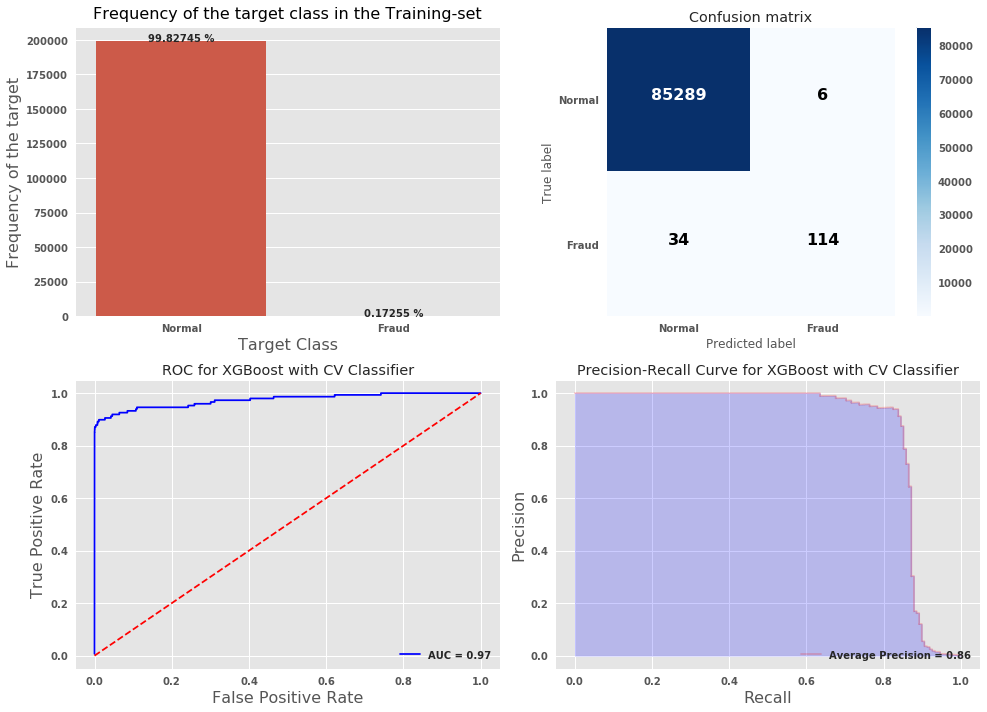

In [71]:
clf_xgb=xgb.XGBClassifier(random_state=0)
params_xgb={'learning_rate':st.uniform(0.01,0.1), 'n_estimators':st.randint(100,300), 'subsample':[0.8,0.9], 'colsample_bytree':[0.8,0.9], 'max_depth' :st.randint(6,15)}
X_train,Y_train,X_test,Y_test=data_prep(data)
xgbrscv=RandomizedSearchCV(clf_xgb, param_distributions=params_xgb,n_iter=15,n_jobs=8,scoring=scored,cv=skf,verbose=True,random_state=0)
xgb_pred6,xgb_probab6=model_fitting_and_post_processing(xgbrscv,X_train,Y_train,X_test,Y_test,clf_name='XGBoost with CV',class_names=['Normal','Fraud'],cross_val=True)

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The accruacy of XGBoost with CV on the Test set:  0.9995435553526912


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     85295
        1.0       0.96      0.77      0.85       148

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



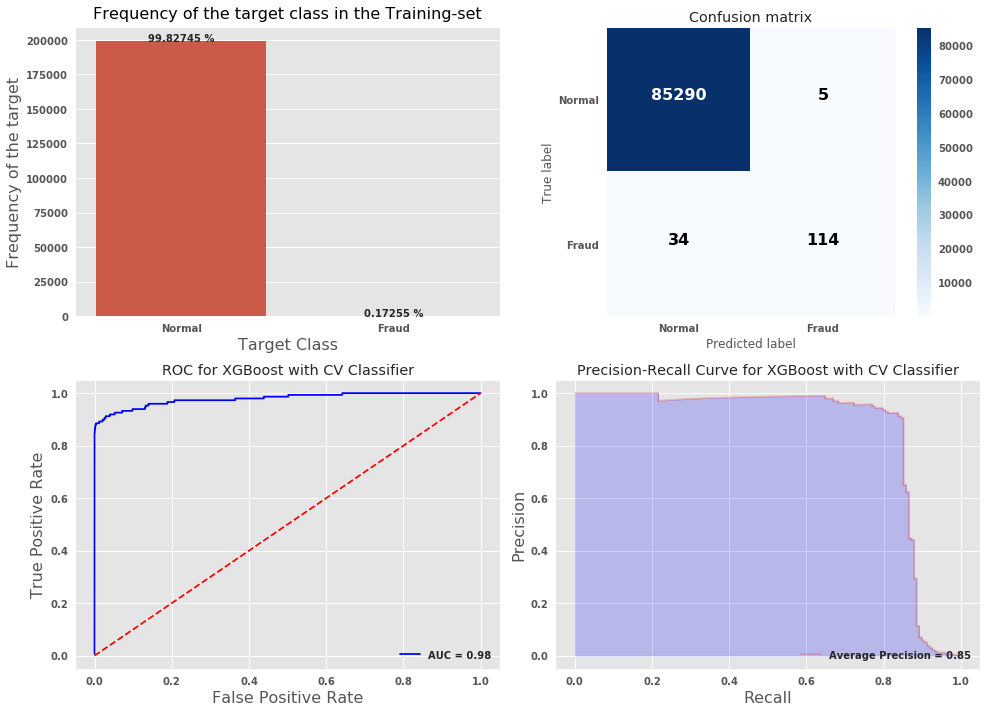

In [73]:
clf_xgb=xgb.XGBClassifier(random_state=0,n_estimators=200,max_depth=5,n_jobs=-1)
X_train,Y_train,X_test,Y_test=feature_engineering(data)
xgb_pred,xgb_probab=model_fitting_and_post_processing(clf_xgb,X_train,Y_train,X_test,Y_test,clf_name='XGBoost with CV',class_names=['Normal','Fraud'])

In [90]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary', 
          'num_leaves': 64, 
          'learning_rate': 0.1, 
          'colsample_bytree': 0.8, 
          'reg_alpha': 5, 
          'reg_lambda': 10,
          'min_split_gain': 0.5, 
          'min_child_weight': 1, 
          'min_child_samples': 5, 
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

In [91]:
import lightgbm as lgb

In [92]:
lgbm=lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = 8,
          silent = True,
          max_depth = params['max_depth'],
          min_split_gain = params['min_split_gain'], 
          min_child_weight = params['min_child_weight'], 
          min_child_samples = params['min_child_samples'], 
          scale_pos_weight = params['scale_pos_weight'])

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The accruacy of LGBM on the Test set:  0.9994382219725431


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     85295
        1.0       0.93      0.73      0.82       148

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



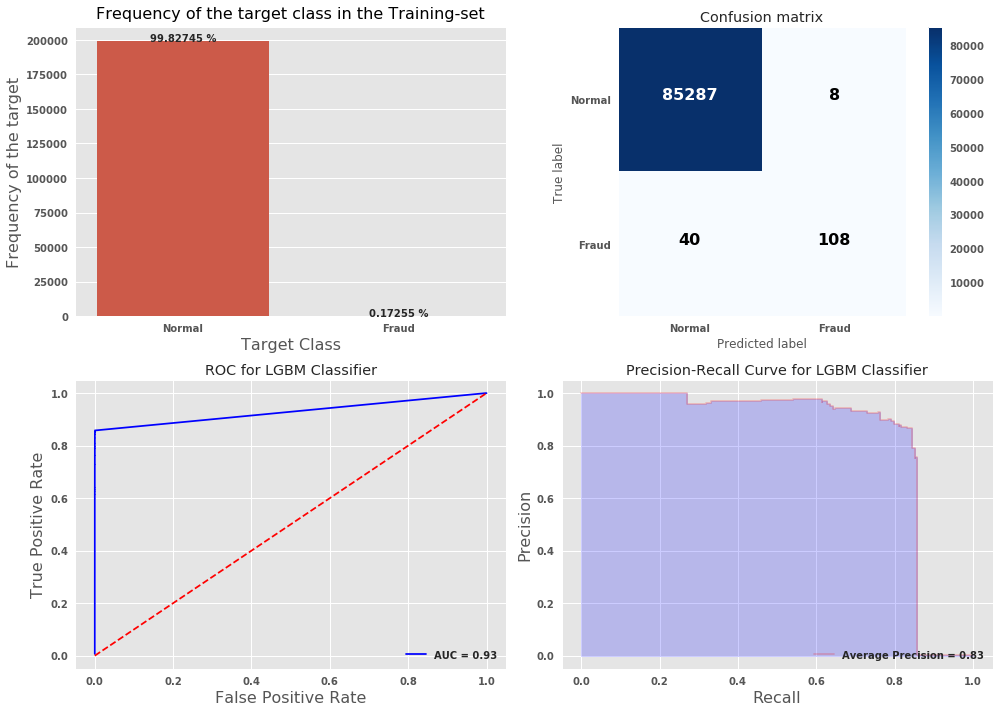

In [93]:
X_train,Y_train,X_test,Y_test=data_prep(data)
lgb_pred,lgb_probab=model_fitting_and_post_processing(lgbm,X_train,Y_train,X_test,Y_test,clf_name='LGBM',class_names=['Normal','Fraud'])

# Neural Networks

In [522]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

#import tensorflow as tf
from keras.layers import Dense, Dropout, Flatten,BatchNormalization
from keras.optimizers import SGD,Adam
import keras.backend as K
import keras.callbacks
from keras import regularizers

In [523]:
X_train,Y_train,X_test,Y_test=feature_engineering(data)

In [524]:
nb_classes=2
l1_num_neuron=300
l2_num_neuron=200
output_neuron=nb_classes

In [525]:
layer_1 = Dense(l1_num_neuron, activation='relu',kernel_regularizer=regularizers.l2(0.01), input_dim=X_train.shape[1])
layer_2 = Dense(l2_num_neuron, activation='relu',kernel_regularizer=regularizers.l2(0.01))
#layer_3 = Dense(l3_num_neuron, activation='relu',kernel_regularizer=regularizers.l2(0.01))
layer_out = Dense(output_neuron, activation='softmax',kernel_regularizer=regularizers.l2(0.01))

In [526]:
mlp=Sequential()
mlp.add(layer_1)
mlp.add(Dropout(0.3))
mlp.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.01))
mlp.add(layer_2)
mlp.add(Dropout(0.3))
mlp.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.01))
#mlp.add(layer_3)
#mlp.add(Dropout(0.3))
#mlp.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.01))
mlp.add(layer_out)

In [527]:
sgd = SGD(lr=0.01, momentum=0.8, decay=0.1/200, nesterov=True)
#adm=Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
mlp.compile(optimizer=sgd,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [528]:
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 300)               11100     
_________________________________________________________________
dropout_66 (Dropout)         (None, 300)               0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 300)               1200      
_________________________________________________________________
dense_84 (Dense)             (None, 200)               60200     
_________________________________________________________________
dropout_67 (Dropout)         (None, 200)               0         
_________________________________________________________________
batch_normalization_67 (Batc (None, 200)               800       
_________________________________________________________________
dense_85 (Dense)             (None, 2)                 402       
Total para

In [529]:
X_train_r,X_val,Y_train_r,Y_val=train_test_split(X_train,Y_train,random_state=0,test_size=0.1,stratify=Y_train.Class)

In [530]:
X_train_r=StandardScaler().fit_transform(X_train_r)
X_val=StandardScaler().fit_transform(X_val)
X_test=StandardScaler().fit_transform(X_test)

In [531]:
from keras.callbacks import EarlyStopping
train_res = mlp.fit(X_train_r,
                      Y_train_r.values.ravel(),
                      batch_size=256,
                      epochs=2000,
                      verbose=True,
                      validation_data=(X_val,Y_val.values.ravel()),
                      callbacks=
                      [EarlyStopping(patience=4,mode='min',
                                     verbose=True)]
                      )

Train on 179427 samples, validate on 19937 samples
Epoch 1/2000
179427/179427 [==============================] - 5s 28us/step - loss: 2.3721 - acc: 0.9803 - val_loss: 1.7131 - val_acc: 0.9991
Epoch 2/2000
179427/179427 [==============================] - 3s 16us/step - loss: 1.3637 - acc: 0.9988 - val_loss: 1.0826 - val_acc: 0.9991
Epoch 3/2000
179427/179427 [==============================] - 3s 16us/step - loss: 0.9006 - acc: 0.9990 - val_loss: 0.7485 - val_acc: 0.9992
Epoch 4/2000
179427/179427 [==============================] - 3s 16us/step - loss: 0.6409 - acc: 0.9991 - val_loss: 0.5491 - val_acc: 0.9991
Epoch 5/2000
179427/179427 [==============================] - 3s 16us/step - loss: 0.4808 - acc: 0.9991 - val_loss: 0.4210 - val_acc: 0.9991
Epoch 6/2000
179427/179427 [==============================] - 3s 16us/step - loss: 0.3748 - acc: 0.9992 - val_loss: 0.3345 - val_acc: 0.9992
Epoch 7/2000
179427/179427 [==============================] - 3s 16us/step - loss: 0.3013 - acc: 0.9992

179427/179427 [==============================] - 3s 16us/step - loss: 0.0169 - acc: 0.9995 - val_loss: 0.0176 - val_acc: 0.9992
Epoch 59/2000
179427/179427 [==============================] - 3s 16us/step - loss: 0.0167 - acc: 0.9994 - val_loss: 0.0175 - val_acc: 0.9991
Epoch 60/2000
179427/179427 [==============================] - 3s 16us/step - loss: 0.0165 - acc: 0.9994 - val_loss: 0.0172 - val_acc: 0.9992
Epoch 61/2000
179427/179427 [==============================] - 3s 16us/step - loss: 0.0162 - acc: 0.9994 - val_loss: 0.0170 - val_acc: 0.9991
Epoch 62/2000
179427/179427 [==============================] - 3s 16us/step - loss: 0.0160 - acc: 0.9995 - val_loss: 0.0169 - val_acc: 0.9991
Epoch 63/2000
179427/179427 [==============================] - 3s 16us/step - loss: 0.0158 - acc: 0.9995 - val_loss: 0.0166 - val_acc: 0.9992
Epoch 64/2000
179427/179427 [==============================] - 3s 16us/step - loss: 0.0156 - acc: 0.9995 - val_loss: 0.0164 - val_acc: 0.9992
Epoch 65/2000
179427

179427/179427 [==============================] - 3s 16us/step - loss: 0.0112 - acc: 0.9994 - val_loss: 0.0121 - val_acc: 0.9991
Epoch 116/2000
179427/179427 [==============================] - 3s 16us/step - loss: 0.0111 - acc: 0.9995 - val_loss: 0.0120 - val_acc: 0.9992
Epoch 117/2000
179427/179427 [==============================] - 3s 16us/step - loss: 0.0111 - acc: 0.9994 - val_loss: 0.0120 - val_acc: 0.9992
Epoch 118/2000
179427/179427 [==============================] - 3s 16us/step - loss: 0.0110 - acc: 0.9994 - val_loss: 0.0120 - val_acc: 0.9991
Epoch 119/2000
179427/179427 [==============================] - 3s 16us/step - loss: 0.0110 - acc: 0.9995 - val_loss: 0.0119 - val_acc: 0.9991
Epoch 120/2000
179427/179427 [==============================] - 3s 16us/step - loss: 0.0109 - acc: 0.9994 - val_loss: 0.0119 - val_acc: 0.9991
Epoch 121/2000
179427/179427 [==============================] - 3s 16us/step - loss: 0.0110 - acc: 0.9994 - val_loss: 0.0118 - val_acc: 0.9992
Epoch 122/2000

179427/179427 [==============================] - 3s 16us/step - loss: 0.0097 - acc: 0.9994 - val_loss: 0.0107 - val_acc: 0.9991
Epoch 173/2000
179427/179427 [==============================] - 3s 16us/step - loss: 0.0098 - acc: 0.9994 - val_loss: 0.0107 - val_acc: 0.9991
Epoch 174/2000
179427/179427 [==============================] - 3s 17us/step - loss: 0.0098 - acc: 0.9994 - val_loss: 0.0107 - val_acc: 0.9992
Epoch 175/2000
179427/179427 [==============================] - 3s 16us/step - loss: 0.0097 - acc: 0.9995 - val_loss: 0.0107 - val_acc: 0.9992
Epoch 176/2000
179427/179427 [==============================] - 3s 15us/step - loss: 0.0098 - acc: 0.9994 - val_loss: 0.0106 - val_acc: 0.9992
Epoch 177/2000
179427/179427 [==============================] - 3s 16us/step - loss: 0.0097 - acc: 0.9994 - val_loss: 0.0106 - val_acc: 0.9992
Epoch 178/2000
179427/179427 [==============================] - 3s 16us/step - loss: 0.0096 - acc: 0.9995 - val_loss: 0.0107 - val_acc: 0.9991
Epoch 179/2000

In [541]:
X_train,Y_train,X_test,Y_test=feature_engineering(data)

In [532]:
predictions=mlp.predict_classes(X_test,verbose=True)

85443/85443 [==============================] - 4s 47us/step


In [533]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test.values.ravel(),predictions)

0.9993679997191109

In [534]:
from sklearn.metrics import recall_score
recall_score(predictions,Y_test.values)

0.873015873015873

In [535]:
from sklearn.metrics import precision_score
precision_score(predictions,Y_test.values)

0.7432432432432432

In [536]:
from sklearn.metrics import f1_score
f1_score(predictions,Y_test.values)

0.8029197080291971

In [537]:
#X_test.head()

In [538]:
post_probab_predictions=mlp.predict_proba(X_test,verbose=True)

85443/85443 [==============================] - 3s 37us/step


In [539]:
#post_probab_predictions

The accruacy of 3 layer Neural network on the Test set:  0.9993679997191109


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     85295
        1.0       0.87      0.74      0.80       148

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



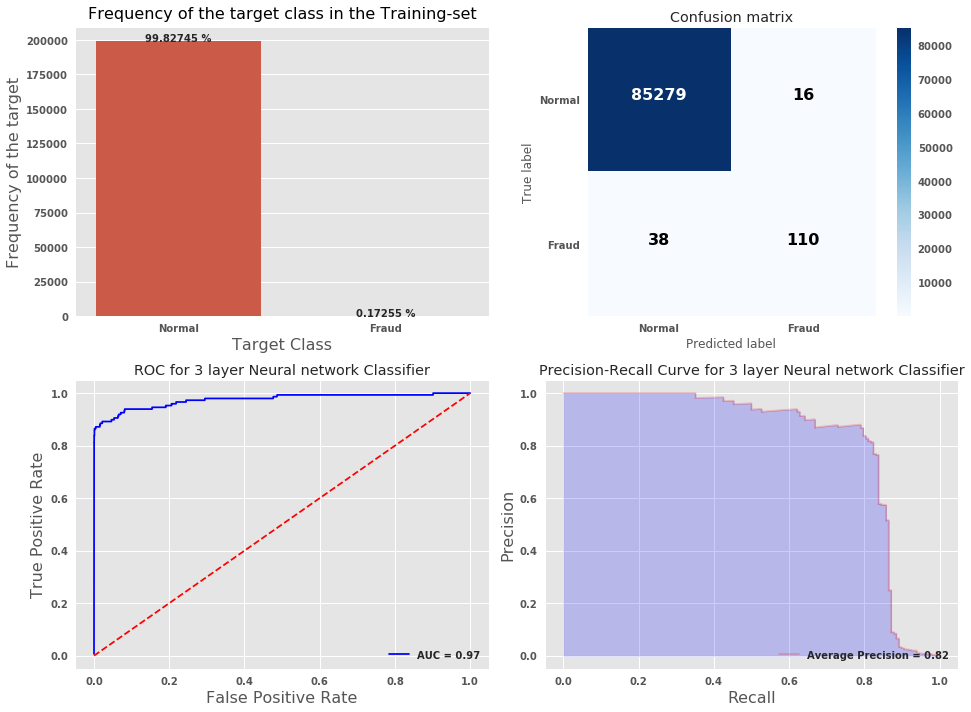

In [540]:
clf_name='3 layer Neural network'
class_names=['Normal','Fraud']
print('The accruacy of %s on the Test set: '%clf_name, accuracy_score(Y_test.values,predictions))
# predicting probabilities
#post_probab_predictions=clf.predict_proba(X_test.values)
# assiging the probability
post_probab_predictions=post_probab_predictions[:,1]
Y_score=post_probab_predictions
# now subplotting
fig, axes=plt.subplots(2,2,figsize=(14,10))
# Class Distribution
plt.sca(axes[0,0])
data_train=X_train.copy()
data_train['Class']=Y_train.values
data_train['Class']=data_train['Class'].map({1.0:'Fraud',0.0:'Normal'})
ax=sns.countplot(x='Class', data=data_train);
total=float(len(data_train))
plt.title('Frequency of the target class in the Training-set',**title_font)
plt.ylabel('Frequency of the target',**axis_font)
plt.xlabel('Target Class',**axis_font)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.5f} %'.format(height*100/total),ha="center")
    #ax.text(p.get_x()+p.get_width()/2.,height - 35,'{:1.5f} '.format(height),ha="center")
    
# Confusion Matrix
cnf_matrix = confusion_matrix(Y_test.values,predictions)
np.set_printoptions(precision=2)
plot_confusion_matrix(axes[0,1],cnf_matrix, classes=class_names, title='Confusion matrix')
axes[0,1].grid('off')
# ROC CURVE
fpr, tpr, thresholds = roc_curve(Y_test.values.ravel(),post_probab_predictions.ravel())
roc_auc = auc(fpr,tpr)
plt.style.use('ggplot')
title_gp='ROC for '+clf_name+' Classifier'
axes[1,0].set_title(title_gp)
axes[1,0].plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
axes[1,0].legend(loc='lower right')
axes[1,0].plot([0,1],[0,1],'r--')
axes[1,0].set_ylabel('True Positive Rate',**axis_font)
axes[1,0].set_xlabel('False Positive Rate',**axis_font)
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(Y_test.values.ravel(), Y_score)
average_precision = average_precision_score(Y_test.values.ravel(), Y_score)
axes[1,1].step(recall, precision, color='red', alpha=0.2,where='post',label='Average Precision = %0.2f'%average_precision)
axes[1,1].fill_between(recall, precision, step='post', alpha=0.2,color='b')
axes[1,1].legend(loc='lower right')
axes[1,1].set_xlabel('Recall',**axis_font)
axes[1,1].set_ylabel('Precision',**axis_font)
title_gp='Precision-Recall Curve for '+clf_name+' Classifier'
axes[1,1].set_title(title_gp)

fig.tight_layout()
print('\n')
print('----------------------- Complete Classification Report -----------------------\n')
print(classification_report(Y_test.values,predictions))
print('\n')
print('--------------------------- Post-processed Plots --------------------------\n')    

# Noise consideration

In [1180]:
X_train,Y_train,X_test,Y_test=feature_engineering(data)

In [1181]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

import tensorflow as tf
from keras.layers import Dense, Dropout, Flatten,BatchNormalization
from keras.optimizers import SGD,Adam
import keras.backend as K
import keras.callbacks
from keras import regularizers

In [1182]:
#seed=0
xcols=X_train.columns.tolist()
nb_classes = 2

In [1183]:
n_train_data,dim=X_train.shape
n_test_data,dim_test=X_test.shape
Y_train=Y_train.values.reshape(n_train_data,1)
Y_test=Y_test.values.reshape(n_test_data,1)

In [1184]:
nhiddens = [300]
DROPOUT=0.1
#opt='adam'
batch_size = 512
patience = 4  # Early stopping patience
epochs = 50  # number of epochs to train on

In [1185]:
def castLabel(y, t):
    if -1 in y:
        if t == -1:
            y_new = y
        elif t == 0:
            y_new = np.divide((y + 1) ,2)
        elif t == 2:
            y_new = np.divide((y + 3),2)
    elif 0 in y:
        if (t == -1):
            y_new = (y * 2) - 1
        elif (t == 0):
            y_new = y
        elif (t == 2):
            y_new = y + 1
    elif 2 in y:
        if (t == -1):
            y_new = (y * 2) - 3
        elif (t == 0):
            y_new = y - 1
        elif (t == 2):
            y_new = y
    return y_new

In [1186]:
def injectLabelNoise(y,flipRate):
    fd  =  -np.ones((y.shape))
    yz  =  castLabel(y,-1)
    y   =  castLabel(y,2)
    # sampling some numbers
    for i in range(0,2):
        prob    = np.random.rand(y.shape[0],1)
        idx     = np.where((y==i+1) & (prob <= flipRate[i]))
        #print(idx)
        yz[idx[0]] = -yz[idx[0]]
        fd[idx[0]] = -fd[idx[0]]
    yz = castLabel(yz,2)
    return yz, fd

In [1187]:
yz, fd=injectLabelNoise(Y_train,[0.1,0.9])
yz=castLabel(yz,0)

In [1188]:
NOISE= round(1. - np.mean(yz == Y_train),1)
NOISE

0.1

In [1189]:
Y_train_noise=yz

In [1190]:
Y_train_noise=Y_train_noise.flatten()

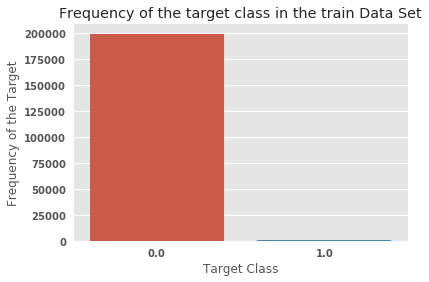

In [1191]:
Y_train_df=pd.DataFrame(Y_train,columns=['Class'])
ax=sns.countplot(x='Class', data=Y_train_df);
total=float(len(Y_train_df))
plt.title('Frequency of the target class in the train Data Set')
plt.ylabel('Frequency of the Target')
plt.xlabel('Target Class')

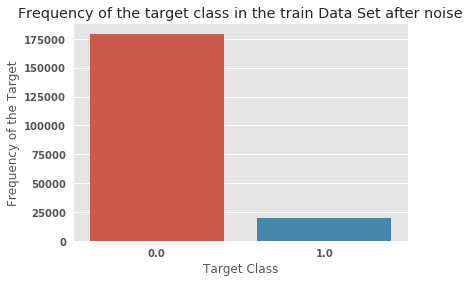

In [1192]:
Y_train_df_noise=pd.DataFrame(Y_train_noise,columns=['Class'])
ax=sns.countplot(x='Class', data=Y_train_df_noise);
total=float(len(Y_train_df_noise))
plt.title('Frequency of the target class in the train Data Set after noise')
plt.ylabel('Frequency of the Target')
plt.xlabel('Target Class')

In [1193]:
from sklearn.model_selection import StratifiedShuffleSplit

In [1194]:
train_idx, val_idx = next(iter(
        StratifiedShuffleSplit(n_splits=1, test_size=0.3,
                               random_state=0).split(X_train, Y_train_noise))) #.values
X_train=X_train.values
X_train_train = X_train[train_idx]
Y_train_train = Y_train_noise[train_idx]
X_train_val = X_train[val_idx]
Y_train_val = Y_train_noise[val_idx]

In [1195]:
from keras import regularizers
from keras.models import Sequential
hidden_layers = Sequential(name='hidden')

In [1196]:
from keras.layers import Dense, Dropout, Activation
for i, nhidden in enumerate(nhiddens):
    hidden_layers.add(Dense(nhidden,kernel_initializer='glorot_normal',kernel_regularizer=regularizers.l2(0.1),
                            input_shape=(X_train.shape[1],) if i == 0 else []))
    hidden_layers.add(Activation('relu'))
    #hidden_layers.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.01))
    hidden_layers.add(Dropout(DROPOUT))

In [1197]:
from keras.layers import Input
train_inputs = Input(shape=(X_train.shape[1],))

In [1198]:
last_hidden = hidden_layers(train_inputs)
baseline_output = Dense(nb_classes, activation='softmax', name='baseline',kernel_initializer='glorot_normal',kernel_regularizer=regularizers.l2(0.01))(last_hidden)

In [1199]:
from keras.models import Model
#sgd = SGD(lr=0.01, momentum=0.8, decay=0.1/200, nesterov=True)

model = Model(inputs=train_inputs, outputs=baseline_output)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [1200]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 36)                0         
_________________________________________________________________
hidden (Sequential)          (None, 300)               11100     
_________________________________________________________________
baseline (Dense)             (None, 2)                 602       
Total params: 11,702
Trainable params: 11,702
Non-trainable params: 0
_________________________________________________________________


In [1201]:
def eval(model,y_test=Y_test):
    return dict(zip(model.metrics_names,model.evaluate(X_test.values,y_test, verbose=False)))

In [1202]:
eval(model)

{'acc': 0.1258499818592512, 'loss': 5.869537799937623}

In [1203]:
from keras.callbacks import EarlyStopping
train_res = model.fit(X_train_train,
                      Y_train_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=True,
                      validation_data=(X_train_val,
                                       Y_train_val),
                      callbacks=
                      [EarlyStopping(patience=patience,mode='min',
                                     verbose=True)]
                      )

Train on 139554 samples, validate on 59810 samples
Epoch 1/50
139554/139554 [==============================] - 6s 43us/step - loss: 1.0911 - acc: 0.8900 - val_loss: 0.3488 - val_acc: 0.8998
Epoch 2/50
139554/139554 [==============================] - 1s 9us/step - loss: 0.3396 - acc: 0.8998 - val_loss: 0.3340 - val_acc: 0.8998
Epoch 3/50
139554/139554 [==============================] - 1s 9us/step - loss: 0.3314 - acc: 0.8998 - val_loss: 0.3295 - val_acc: 0.8998
Epoch 4/50
139554/139554 [==============================] - 1s 9us/step - loss: 0.3291 - acc: 0.8998 - val_loss: 0.3294 - val_acc: 0.8998
Epoch 5/50
139554/139554 [==============================] - 1s 9us/step - loss: 0.3284 - acc: 0.8998 - val_loss: 0.3282 - val_acc: 0.8998
Epoch 6/50
139554/139554 [==============================] - 1s 9us/step - loss: 0.3279 - acc: 0.8998 - val_loss: 0.3279 - val_acc: 0.8998
Epoch 7/50
139554/139554 [==============================] - 1s 9us/step - loss: 0.3276 - acc: 0.8998 - val_loss: 0.3272 

In [1204]:
eval(model)

{'acc': 0.9982678510820079, 'loss': 0.1256974948341212}

In [1205]:
ybaseline_predict = model.predict(X_train,batch_size=batch_size)

In [1206]:
ybaseline_predict = np.argmax(ybaseline_predict, axis=-1)

In [1207]:
ybaseline_predict=ybaseline_predict.reshape(ybaseline_predict.shape[0],1)

In [1208]:
ybaseline_predict.shape

(199364, 1)

In [1209]:
Y_train_noise=Y_train_noise.flatten()

In [1210]:
Y_train_noise=pd.DataFrame(Y_train_noise,columns=['Class'])

In [1211]:
Y_train_noise=Y_train_noise.astype('int')

In [1212]:
Y_train_noise.head()

,Class
0,0
1,0
2,0
3,0
4,0


In [1213]:
baseline_confusion = np.zeros((nb_classes, nb_classes))
for n, p in zip(Y_train_noise.values.ravel(), ybaseline_predict):
    baseline_confusion[p, n] += 1.

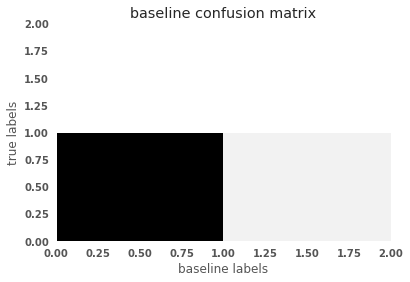

In [1214]:
import matplotlib.pyplot as plt
%matplotlib inline
# perm_bias_weights.astype(int)
plt.pcolor(baseline_confusion)
plt.ylabel('true labels')
plt.xlabel('baseline labels')
plt.title('baseline confusion matrix');

In [1215]:
BETA = 0

In [1216]:
channel_weights = baseline_confusion.copy()
channel_weights=channel_weights + 1e-8
channel_weights /= channel_weights.sum(axis=1, keepdims=True)
# perm_bias_weights[prediction,noisy_label] = log(P(noisy_label|prediction))
#channel_weights = np.log(channel_weights+1e-8)

In [1217]:
channel_weights

array([[0.9, 0.1],
       [0.5, 0.5]])

In [1218]:
from channel import Channel
channeled_output = Channel(name='channel',weights=[channel_weights],kernel_initializer='glorot_normal',kernel_regularizer=regularizers.l2(0.01))(baseline_output)

In [1219]:
if BETA ==1:
    simple_model = Model(inputs=train_inputs, outputs=[baseline_output])
    simple_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
else:
    simple_model = Model(inputs=train_inputs, outputs=[channeled_output, baseline_output])
    simple_model.compile(loss='sparse_categorical_crossentropy',loss_weights=[1.-BETA, BETA],optimizer='adam',metrics=['accuracy'])

In [1220]:
simple_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 36)                0         
_________________________________________________________________
hidden (Sequential)          (None, 300)               11100     
_________________________________________________________________
baseline (Dense)             (None, 2)                 602       
_________________________________________________________________
channel (Channel)            (None, 2)                 4         
Total params: 11,706
Trainable params: 11,706
Non-trainable params: 0
_________________________________________________________________


In [1221]:
train_res = simple_model.fit(X_train_train,
                      [Y_train_train,Y_train_train],
                      batch_size=batch_size,
                      epochs=100,
                      verbose=True,
                      validation_data=(X_train_val,
                                       [Y_train_val,Y_train_val]),
                      callbacks=
                      [EarlyStopping(patience=3,mode='min',verbose=True)]
                      )

Train on 139554 samples, validate on 59810 samples
Epoch 1/100
139554/139554 [==============================] - 7s 47us/step - loss: 0.4256 - channel_loss: 0.4085 - baseline_loss: 0.4901 - channel_acc: 0.8998 - baseline_acc: 0.8998 - val_loss: 0.3921 - val_channel_loss: 0.3747 - val_baseline_loss: 0.5251 - val_channel_acc: 0.8998 - val_baseline_acc: 0.8998
Epoch 2/100
139554/139554 [==============================] - 1s 9us/step - loss: 0.3759 - channel_loss: 0.3575 - baseline_loss: 0.5393 - channel_acc: 0.8998 - baseline_acc: 0.8998 - val_loss: 0.3645 - val_channel_loss: 0.3449 - val_baseline_loss: 0.5380 - val_channel_acc: 0.8998 - val_baseline_acc: 0.8998
Epoch 3/100
139554/139554 [==============================] - 1s 9us/step - loss: 0.3593 - channel_loss: 0.3385 - baseline_loss: 0.5523 - channel_acc: 0.8998 - baseline_acc: 0.8998 - val_loss: 0.3557 - val_channel_loss: 0.3339 - val_baseline_loss: 0.5430 - val_channel_acc: 0.8998 - val_baseline_acc: 0.8998
Epoch 4/100
139554/139554 [

139554/139554 [==============================] - 1s 9us/step - loss: 0.3473 - channel_loss: 0.3275 - baseline_loss: 0.7608 - channel_acc: 0.8998 - baseline_acc: 0.8998 - val_loss: 0.3473 - val_channel_loss: 0.3273 - val_baseline_loss: 0.7977 - val_channel_acc: 0.8998 - val_baseline_acc: 0.8998
Epoch 28/100
139554/139554 [==============================] - 1s 10us/step - loss: 0.3473 - channel_loss: 0.3274 - baseline_loss: 0.7726 - channel_acc: 0.8998 - baseline_acc: 0.8998 - val_loss: 0.3473 - val_channel_loss: 0.3275 - val_baseline_loss: 0.7757 - val_channel_acc: 0.8998 - val_baseline_acc: 0.8998
Epoch 29/100
139554/139554 [==============================] - 1s 9us/step - loss: 0.3473 - channel_loss: 0.3274 - baseline_loss: 0.7817 - channel_acc: 0.8998 - baseline_acc: 0.8998 - val_loss: 0.3473 - val_channel_loss: 0.3274 - val_baseline_loss: 0.7430 - val_channel_acc: 0.8998 - val_baseline_acc: 0.8998
Epoch 30/100
139554/139554 [==============================] - 1s 9us/step - loss: 0.3473

In [1222]:
eval(simple_model,y_test=[Y_test,Y_test])

{'baseline_acc': 0.9982678510820079,
 'baseline_loss': 0.017726336896155104,
 'channel_acc': 0.9982678510820079,
 'channel_loss': 0.13266238394035595,
 'loss': 0.1522840839888026}

In [1223]:
preds=simple_model.predict(X_test.values)

In [1224]:
preds_max=np.argmax(preds[0],axis=-1)

In [1225]:
predictions=preds_max

In [1226]:
#X_train,Y_train,X_test,Y_test=data_prep(data)

In [1227]:
#Y_test

The accruacy of 3 layer Neural network on the Test set:  0.9982678510820079


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     85295
        1.0       0.00      0.00      0.00       148

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



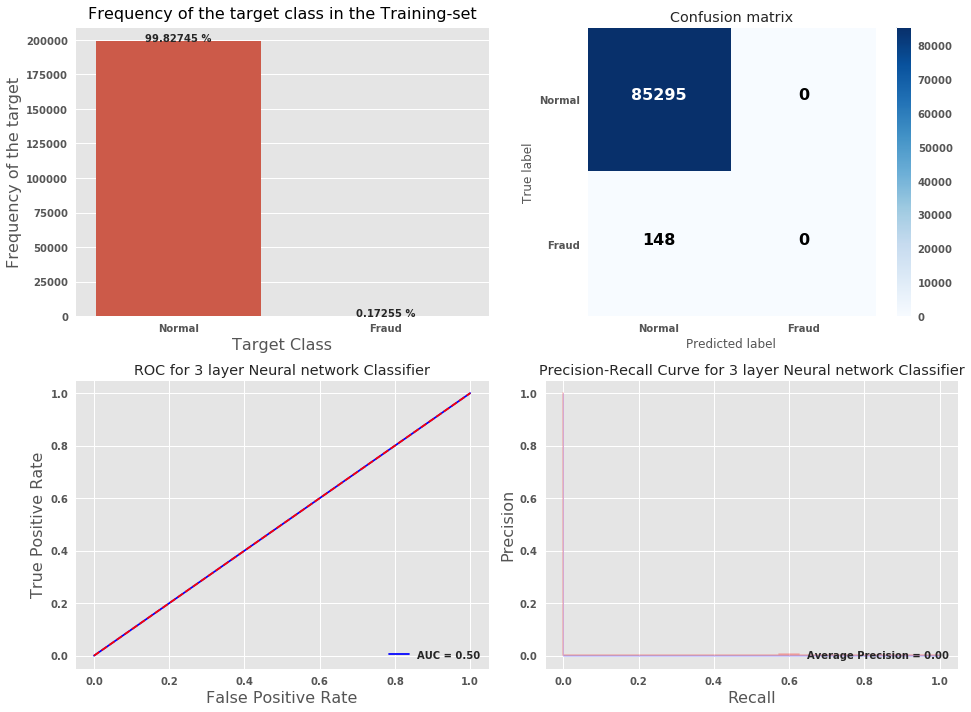

In [1228]:
clf_name='3 layer Neural network'
class_names=['Normal','Fraud']
print('The accruacy of %s on the Test set: '%clf_name, accuracy_score(Y_test,predictions))
# predicting probabilities
#post_probab_predictions=clf.predict_proba(X_test.values)
# assiging the probability
post_probab_predictions=predictions
Y_score=post_probab_predictions
# now subplotting
fig, axes=plt.subplots(2,2,figsize=(14,10))
# Class Distribution
plt.sca(axes[0,0])
data_train=pd.DataFrame(X_train,columns=xcols)
#data_train=X_train.copy()
data_train['Class']=Y_train
data_train['Class']=data_train['Class'].map({1.0:'Fraud',0.0:'Normal'})
ax=sns.countplot(x='Class', data=data_train);
total=float(len(data_train))
plt.title('Frequency of the target class in the Training-set',**title_font)
plt.ylabel('Frequency of the target',**axis_font)
plt.xlabel('Target Class',**axis_font)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.5f} %'.format(height*100/total),ha="center")
    #ax.text(p.get_x()+p.get_width()/2.,height - 35,'{:1.5f} '.format(height),ha="center")
    
# Confusion Matrix
cnf_matrix = confusion_matrix(Y_test,predictions)
np.set_printoptions(precision=2)
plot_confusion_matrix(axes[0,1],cnf_matrix, classes=class_names, title='Confusion matrix')
axes[0,1].grid('off')
# ROC CURVE
fpr, tpr, thresholds = roc_curve(Y_test.ravel(),post_probab_predictions.ravel())
roc_auc = auc(fpr,tpr)
plt.style.use('ggplot')
title_gp='ROC for '+clf_name+' Classifier'
axes[1,0].set_title(title_gp)
axes[1,0].plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
axes[1,0].legend(loc='lower right')
axes[1,0].plot([0,1],[0,1],'r--')
axes[1,0].set_ylabel('True Positive Rate',**axis_font)
axes[1,0].set_xlabel('False Positive Rate',**axis_font)
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(Y_test.ravel(), Y_score)
average_precision = average_precision_score(Y_test.ravel(), Y_score)
axes[1,1].step(recall, precision, color='red', alpha=0.2,where='post',label='Average Precision = %0.2f'%average_precision)
axes[1,1].fill_between(recall, precision, step='post', alpha=0.2,color='b')
axes[1,1].legend(loc='lower right')
axes[1,1].set_xlabel('Recall',**axis_font)
axes[1,1].set_ylabel('Precision',**axis_font)
title_gp='Precision-Recall Curve for '+clf_name+' Classifier'
axes[1,1].set_title(title_gp)

fig.tight_layout()
print('\n')
print('----------------------- Complete Classification Report -----------------------\n')
print(classification_report(Y_test,predictions))
print('\n')
print('--------------------------- Post-processed Plots --------------------------\n')    

In [1078]:
from keras.layers import merge
from keras.layers import concatenate
from keras.layers import Dot
from keras.layers import Reshape

In [1079]:
channel_matrix = [Dense(nb_classes,activation='softmax',kernel_regularizer=regularizers.l2(0.01),name='dense_class%d'%i,weights=[0.05*(np.random.random((nhidden,nb_classes)) - 0.5),channel_weights[i]])(last_hidden)for i in range(nb_classes)]
channel_matrix = concatenate(channel_matrix)
channel_matrix = Reshape((nb_classes,nb_classes))(channel_matrix)
channeled_output = merge([channel_matrix, baseline_output], mode='dot', dot_axes=(1,1), name='channel')

In [1080]:
if BETA ==1:
    complex_model = Model(inputs=train_inputs, outputs=[baseline_output])
    complex_model.compile(loss='sparse_categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
else:
    complex_model = Model(inputs=train_inputs, outputs=[channeled_output, baseline_output])
    complex_model.compile(loss='sparse_categorical_crossentropy',loss_weights=[1.-BETA, BETA],optimizer=sgd,metrics=['accuracy'])

In [1081]:
complex_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 29)           0                                            
__________________________________________________________________________________________________
hidden (Sequential)             (None, 300)          168500      input_13[0][0]                   
__________________________________________________________________________________________________
dense_class0 (Dense)            (None, 2)            602         hidden[1][0]                     
__________________________________________________________________________________________________
dense_class1 (Dense)            (None, 2)            602         hidden[1][0]                     
__________________________________________________________________________________________________
concatenat

In [1082]:
train_res_complex = complex_model.fit(X_train_train,
                      [Y_train_train,Y_train_train],
                      batch_size=batch_size,
                      epochs=2000,
                      verbose=True,
                      validation_data=(X_train_val,
                                       [Y_train_val,Y_train_val]),
                      callbacks=
                      [EarlyStopping(patience=4,mode='min',verbose=True)]
                      )

Train on 139554 samples, validate on 59810 samples
Epoch 1/2000
139554/139554 [==============================] - 14s 102us/step - loss: 0.6749 - channel_loss: 0.6724 - baseline_loss: 2.1013 - channel_acc: 0.6019 - baseline_acc: 0.6019 - val_loss: 0.6746 - val_channel_loss: 0.6723 - val_baseline_loss: 2.1003 - val_channel_acc: 0.6019 - val_baseline_acc: 0.6019
Epoch 2/2000
139554/139554 [==============================] - 9s 64us/step - loss: 0.6746 - channel_loss: 0.6723 - baseline_loss: 2.0994 - channel_acc: 0.6019 - baseline_acc: 0.6019 - val_loss: 0.6743 - val_channel_loss: 0.6722 - val_baseline_loss: 2.0985 - val_channel_acc: 0.6019 - val_baseline_acc: 0.6019
Epoch 3/2000
139554/139554 [==============================] - 9s 64us/step - loss: 0.6743 - channel_loss: 0.6723 - baseline_loss: 2.0976 - channel_acc: 0.6019 - baseline_acc: 0.6019 - val_loss: 0.6742 - val_channel_loss: 0.6723 - val_baseline_loss: 2.0967 - val_channel_acc: 0.6019 - val_baseline_acc: 0.6019
Epoch 4/2000
139554/

139554/139554 [==============================] - 9s 64us/step - loss: 0.6726 - channel_loss: 0.6723 - baseline_loss: 2.0754 - channel_acc: 0.6019 - baseline_acc: 0.6019 - val_loss: 0.6726 - val_channel_loss: 0.6722 - val_baseline_loss: 2.0751 - val_channel_acc: 0.6019 - val_baseline_acc: 0.6019
Epoch 28/2000
139554/139554 [==============================] - 9s 64us/step - loss: 0.6726 - channel_loss: 0.6723 - baseline_loss: 2.0749 - channel_acc: 0.6019 - baseline_acc: 0.6019 - val_loss: 0.6725 - val_channel_loss: 0.6722 - val_baseline_loss: 2.0747 - val_channel_acc: 0.6019 - val_baseline_acc: 0.6019
Epoch 29/2000
139554/139554 [==============================] - 9s 63us/step - loss: 0.6725 - channel_loss: 0.6722 - baseline_loss: 2.0745 - channel_acc: 0.6019 - baseline_acc: 0.6019 - val_loss: 0.6725 - val_channel_loss: 0.6722 - val_baseline_loss: 2.0743 - val_channel_acc: 0.6019 - val_baseline_acc: 0.6019
Epoch 30/2000
139554/139554 [==============================] - 9s 64us/step - loss: 

139554/139554 [==============================] - 9s 65us/step - loss: 0.6724 - channel_loss: 0.6723 - baseline_loss: 2.0678 - channel_acc: 0.6019 - baseline_acc: 0.6019 - val_loss: 0.6723 - val_channel_loss: 0.6722 - val_baseline_loss: 2.0677 - val_channel_acc: 0.6019 - val_baseline_acc: 0.6019
Epoch 54/2000
139554/139554 [==============================] - 9s 65us/step - loss: 0.6724 - channel_loss: 0.6723 - baseline_loss: 2.0676 - channel_acc: 0.6019 - baseline_acc: 0.6019 - val_loss: 0.6723 - val_channel_loss: 0.6722 - val_baseline_loss: 2.0675 - val_channel_acc: 0.6019 - val_baseline_acc: 0.6019
Epoch 55/2000
139554/139554 [==============================] - 9s 64us/step - loss: 0.6723 - channel_loss: 0.6722 - baseline_loss: 2.0674 - channel_acc: 0.6019 - baseline_acc: 0.6019 - val_loss: 0.6723 - val_channel_loss: 0.6722 - val_baseline_loss: 2.0673 - val_channel_acc: 0.6019 - val_baseline_acc: 0.6019
Epoch 56/2000
139554/139554 [==============================] - 9s 64us/step - loss: 

139554/139554 [==============================] - 9s 64us/step - loss: 0.6723 - channel_loss: 0.6722 - baseline_loss: 2.0645 - channel_acc: 0.6019 - baseline_acc: 0.6019 - val_loss: 0.6723 - val_channel_loss: 0.6722 - val_baseline_loss: 2.0645 - val_channel_acc: 0.6019 - val_baseline_acc: 0.6019
Epoch 80/2000
139554/139554 [==============================] - 9s 65us/step - loss: 0.6723 - channel_loss: 0.6722 - baseline_loss: 2.0644 - channel_acc: 0.6019 - baseline_acc: 0.6019 - val_loss: 0.6723 - val_channel_loss: 0.6722 - val_baseline_loss: 2.0644 - val_channel_acc: 0.6019 - val_baseline_acc: 0.6019
Epoch 81/2000
139554/139554 [==============================] - 9s 64us/step - loss: 0.6723 - channel_loss: 0.6723 - baseline_loss: 2.0644 - channel_acc: 0.6019 - baseline_acc: 0.6019 - val_loss: 0.6723 - val_channel_loss: 0.6722 - val_baseline_loss: 2.0643 - val_channel_acc: 0.6019 - val_baseline_acc: 0.6019
Epoch 82/2000
139554/139554 [==============================] - 9s 65us/step - loss: 

In [1083]:
eval(complex_model,y_test=[Y_test,Y_test])

{'baseline_acc': 0.9982678510820079,
 'baseline_loss': 0.014619355319389623,
 'channel_acc': 0.9982678510820079,
 'channel_loss': 0.5118897984270709,
 'loss': 0.5119283030275958}

In [1084]:
preds_complex=complex_model.predict(X_test.values)

In [1085]:
preds_max_complex=np.argmax(preds_complex[0],axis=-1)

In [1086]:
preds_max_complex.shape

(85443,)

In [1462]:
predictions=preds_max_complex

The accruacy of 4 layer Neural network on the Test set:  0.9982678510820079


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     85295
        1.0       0.00      0.00      0.00       148

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



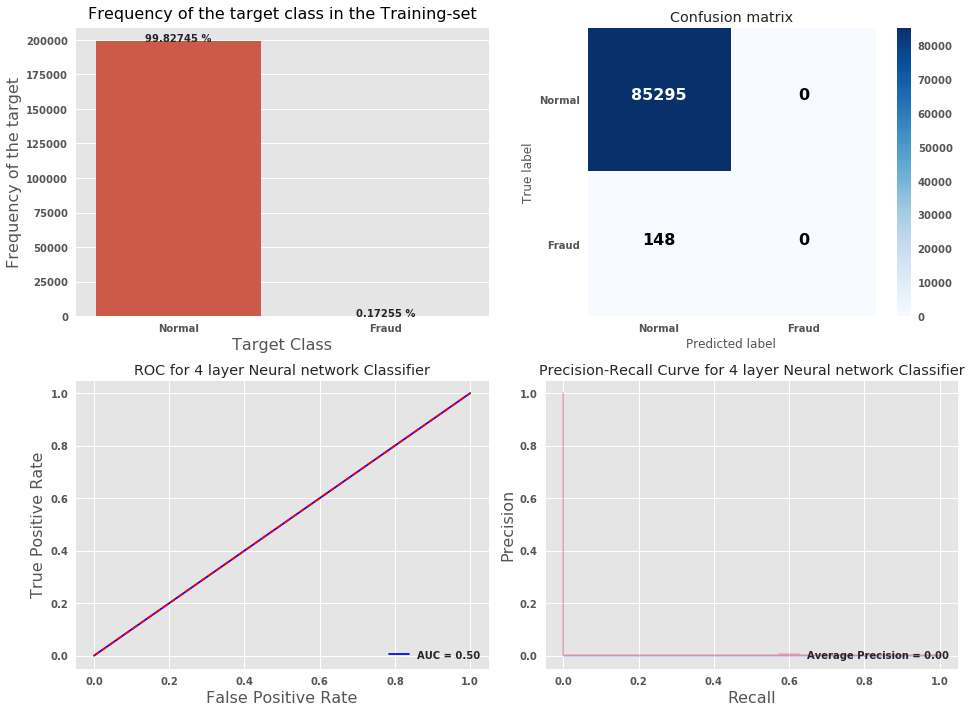

In [1466]:
clf_name='4 layer Neural network'
class_names=['Normal','Fraud']
print('The accruacy of %s on the Test set: '%clf_name, accuracy_score(Y_test,predictions))
# predicting probabilities
#post_probab_predictions=clf.predict_proba(X_test.values)
# assiging the probability
post_probab_predictions=predictions
Y_score=post_probab_predictions
# now subplotting
fig, axes=plt.subplots(2,2,figsize=(14,10))
# Class Distribution
plt.sca(axes[0,0])
data_train=pd.DataFrame(X_train,columns=xcols)
#data_train=X_train.copy()
data_train['Class']=Y_train
data_train['Class']=data_train['Class'].map({1.0:'Fraud',0.0:'Normal'})
ax=sns.countplot(x='Class', data=data_train);
total=float(len(data_train))
plt.title('Frequency of the target class in the Training-set',**title_font)
plt.ylabel('Frequency of the target',**axis_font)
plt.xlabel('Target Class',**axis_font)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.5f} %'.format(height*100/total),ha="center")
    #ax.text(p.get_x()+p.get_width()/2.,height - 35,'{:1.5f} '.format(height),ha="center")
    
# Confusion Matrix
cnf_matrix = confusion_matrix(Y_test,predictions)
np.set_printoptions(precision=2)
plot_confusion_matrix(axes[0,1],cnf_matrix, classes=class_names, title='Confusion matrix')
axes[0,1].grid('off')
# ROC CURVE
fpr, tpr, thresholds = roc_curve(Y_test.values.ravel(),post_probab_predictions.ravel())
roc_auc = auc(fpr,tpr)
plt.style.use('ggplot')
title_gp='ROC for '+clf_name+' Classifier'
axes[1,0].set_title(title_gp)
axes[1,0].plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
axes[1,0].legend(loc='lower right')
axes[1,0].plot([0,1],[0,1],'r--')
axes[1,0].set_ylabel('True Positive Rate',**axis_font)
axes[1,0].set_xlabel('False Positive Rate',**axis_font)
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(Y_test.values.ravel(), Y_score)
average_precision = average_precision_score(Y_test.values.ravel(), Y_score)
axes[1,1].step(recall, precision, color='red', alpha=0.2,where='post',label='Average Precision = %0.2f'%average_precision)
axes[1,1].fill_between(recall, precision, step='post', alpha=0.2,color='b')
axes[1,1].legend(loc='lower right')
axes[1,1].set_xlabel('Recall',**axis_font)
axes[1,1].set_ylabel('Precision',**axis_font)
title_gp='Precision-Recall Curve for '+clf_name+' Classifier'
axes[1,1].set_title(title_gp)

fig.tight_layout()
print('\n')
print('----------------------- Complete Classification Report -----------------------\n')
print(classification_report(Y_test,predictions))
print('\n')
print('--------------------------- Post-processed Plots --------------------------\n')    

# Using anomaly detection

In [1340]:
def plt_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #plt.sca(axd)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        1#print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",size=16)
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [1463]:
X_train,Y_train,X_test,Y_test=feature_engineering(data)

In [1446]:
X_train['Class']=Y_train['Class']

In [1447]:
X_train_normal=X_train[X_train['Class']==0]
X_outliers=X_train[X_train['Class']==1]

In [1448]:
X_train_normal.drop('Class',axis=1,inplace=True)
X_outliers.drop('Class',axis=1,inplace=True)

In [1449]:
from sklearn.ensemble import IsolationForest

In [1450]:
# fit the model
clf = IsolationForest(max_samples=0.95, random_state=0,contamination=0.0017255,n_jobs=8)
clf.fit(X_train_normal.values)
y_pred_train = clf.predict(X_train_normal.values)
y_pred_test = clf.predict(X_test.values)
y_pred_outliers = clf.predict(X_outliers.values)

In [1451]:
y_pred_train=pd.DataFrame(y_pred_train,columns=['train'])
y_pred_test=pd.DataFrame(y_pred_test,columns=['test'])
y_pred_outliers=pd.DataFrame(y_pred_outliers,columns=['outliers'])

In [1452]:
y_pred_train.train.value_counts()

 1    198676
-1       344
Name: train, dtype: int64

In [1453]:
y_pred_test.test.value_counts()

 1    85172
-1      271
Name: test, dtype: int64

In [1454]:
y_pred_outliers.outliers.value_counts()

-1    279
 1     65
Name: outliers, dtype: int64

In [1455]:
Y_test['Class']=Y_test['Class'].map({0.0:1,1.0:-1})

In [1456]:
print(classification_report(Y_test.values,y_pred_test.values))

             precision    recall  f1-score   support

         -1       0.45      0.82      0.58       148
          1       1.00      1.00      1.00     85295

avg / total       1.00      1.00      1.00     85443



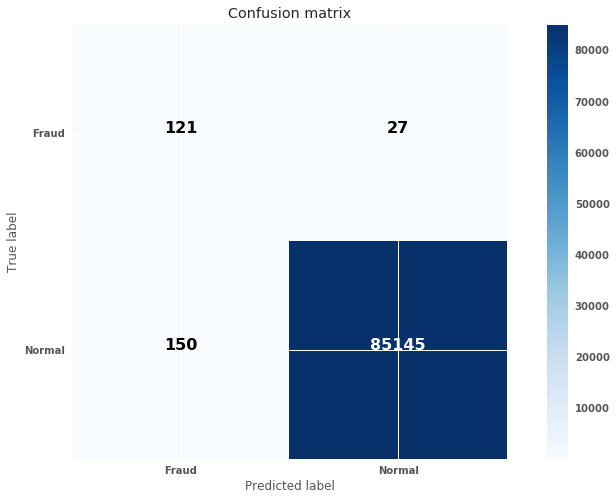

In [1457]:
cnf_matrix = confusion_matrix(Y_test.values,y_pred_test.values)
np.set_printoptions(precision=2)
plt_confusion_matrix(cnf_matrix, classes=['Fraud','Normal'], title='Confusion matrix')

In [1458]:
Y_score=clf.decision_function(X_test.values)

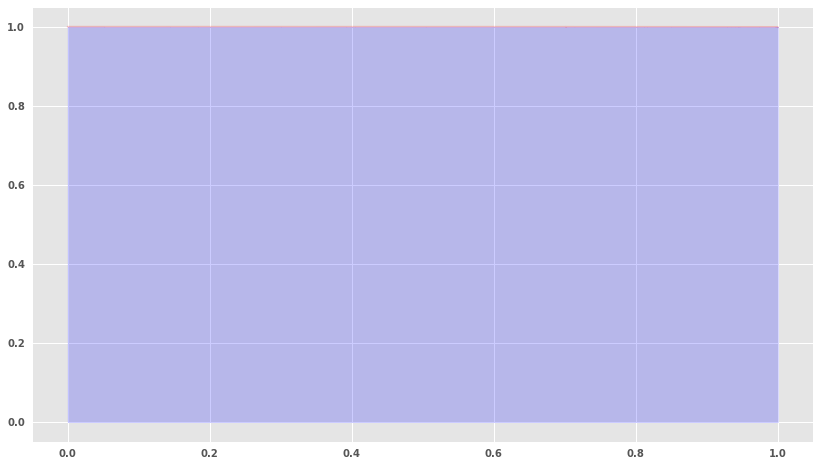

In [1461]:
precision, recall, _ = precision_recall_curve(Y_test.values,Y_score)
average_precision = average_precision_score(Y_test.values,y_pred_test.values)
plt.step(recall, precision, color='red', alpha=0.2,where='post',label='Average Precision = %0.2f'%average_precision)
#plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')

The accruacy of Isolation Forest on the Test set:  0.9979284435237527


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

         -1       0.45      0.82      0.58       148
          1       1.00      1.00      1.00     85295

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



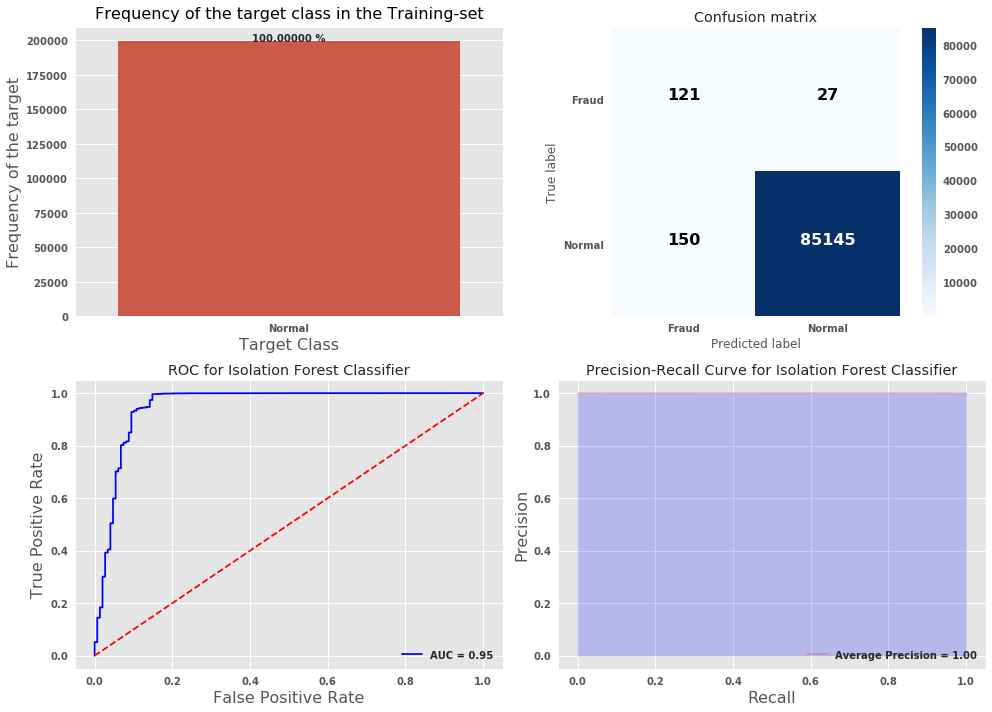

In [1459]:
clf_name='Isolation Forest'
#Y_test['Class']=Y_test['Class'].map({1:0.0,-1:1.0})
#y_pred_test['test']=y_pred_test['test'].map({1:0.0,-1:1.0})
class_names=['Fraud','Normal']
print('The accruacy of %s on the Test set: '%clf_name, accuracy_score(Y_test.values,y_pred_test.values))
# predicting probabilities
#post_probab_predictions=clf.predict_proba(X_test.values)
# assiging the probability
#post_probab_predictions=post_probab_predictions[:,1]
#Y_score=post_probab_predictions
# now subplotting
fig, axes=plt.subplots(2,2,figsize=(14,10))
# Class Distribution
plt.sca(axes[0,0])
data_train=X_train.copy()
data_train['Class']=Y_train.values
data_train['Class']=data_train['Class'].map({1.0:'Normal',0.0:'Normal'})
ax=sns.countplot(x='Class', data=data_train);
total=float(len(data_train))
plt.title('Frequency of the target class in the Training-set',**title_font)
plt.ylabel('Frequency of the target',**axis_font)
plt.xlabel('Target Class',**axis_font)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.5f} %'.format(height*100/total),ha="center")
    #ax.text(p.get_x()+p.get_width()/2.,height - 35,'{:1.5f} '.format(height),ha="center")
    
# Confusion Matrix

cnf_matrix = confusion_matrix(Y_test.values,y_pred_test.values)
np.set_printoptions(precision=2)
plot_confusion_matrix(axes[0,1],cnf_matrix, classes=class_names, title='Confusion matrix')
axes[0,1].grid('off')
# ROC CURVE
fpr, tpr, thresholds = roc_curve(Y_test.values.ravel(),Y_score)
roc_auc = auc(fpr,tpr)
plt.style.use('ggplot')
title_gp='ROC for '+clf_name+' Classifier'
axes[1,0].set_title(title_gp)
axes[1,0].plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
axes[1,0].legend(loc='lower right')
axes[1,0].plot([0,1],[0,1],'r--')
axes[1,0].set_ylabel('True Positive Rate',**axis_font)
axes[1,0].set_xlabel('False Positive Rate',**axis_font)
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(Y_test.values,Y_score)
average_precision = average_precision_score(Y_test.values,y_pred_test.values)
axes[1,1].step(recall, precision, color='red', alpha=0.2,where='post',label='Average Precision = %0.2f'%average_precision)
#.step(recall, precision, color='red', alpha=0.2,where='post',label='Average Precision = %0.2f'%average_precision)
axes[1,1].fill_between(recall, precision, step='post', alpha=0.2,color='b')
axes[1,1].legend(loc='lower right')
axes[1,1].set_xlabel('Recall',**axis_font)
axes[1,1].set_ylabel('Precision',**axis_font)
title_gp='Precision-Recall Curve for '+clf_name+' Classifier'
axes[1,1].set_title(title_gp)

fig.tight_layout()
print('\n')
print('----------------------- Complete Classification Report -----------------------\n')
print(classification_report(Y_test.values,y_pred_test.values))
print('\n')
print('--------------------------- Post-processed Plots --------------------------\n')    

# Using auto encoder

In [1346]:
X_train,Y_train,X_test,Y_test=feature_engineering(data)

In [1347]:
X_train = X_train.values
X_test = X_test.values

Y_train = Y_train.values
Y_test = Y_test.values

In [1343]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [1354]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [1355]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [1356]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard,EarlyStopping(patience=4,mode='min',verbose=True)]).history

Train on 199364 samples, validate on 85443 samples
Epoch 1/100
199364/199364 [==============================] - 21s 106us/step - loss: 0.5454 - acc: 0.6357 - val_loss: 0.5067 - val_acc: 0.6898
Epoch 2/100
199364/199364 [==============================] - 16s 82us/step - loss: 0.5036 - acc: 0.7008 - val_loss: 0.4986 - val_acc: 0.7085
Epoch 3/100
199364/199364 [==============================] - 17s 83us/step - loss: 0.4982 - acc: 0.7089 - val_loss: 0.4934 - val_acc: 0.7074
Epoch 4/100
199364/199364 [==============================] - 17s 83us/step - loss: 0.4920 - acc: 0.7123 - val_loss: 0.4851 - val_acc: 0.7200
Epoch 5/100
199364/199364 [==============================] - 17s 83us/step - loss: 0.4869 - acc: 0.7155 - val_loss: 0.4830 - val_acc: 0.7051
Epoch 6/100
199364/199364 [==============================] - 17s 83us/step - loss: 0.4852 - acc: 0.7176 - val_loss: 0.4818 - val_acc: 0.7220
Epoch 7/100
199364/199364 [==============================] - 17s 84us/step - loss: 0.4839 - acc: 0.717

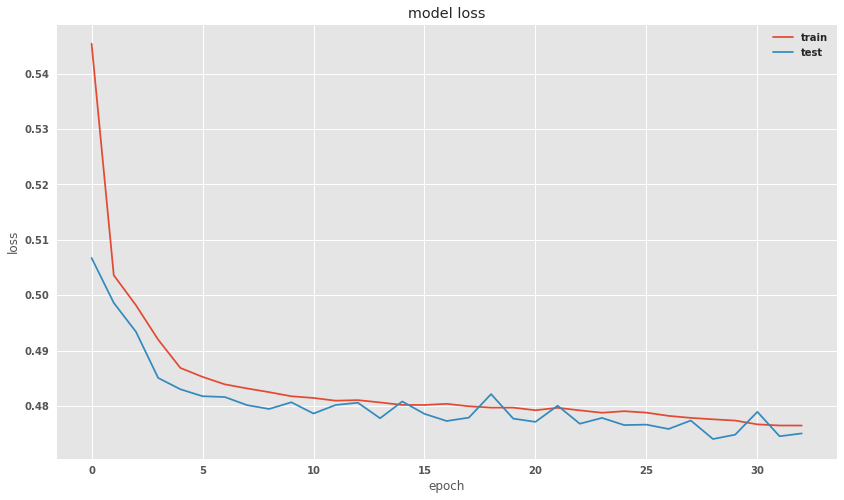

In [1358]:
autoencoder = load_model('model.h5')
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [1362]:
predictions = autoencoder.predict(X_test)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': Y_test.ravel()})

In [1363]:
error_df.describe()

,reconstruction_error,true_class
count,85443.000000,85443.000000
mean,0.469303,0.001732
std,2.237842,0.041583
min,0.010091,0.000000
25%,0.130715,0.000000
50%,0.234930,0.000000
75%,0.423768,0.000000
max,151.820325,1.000000


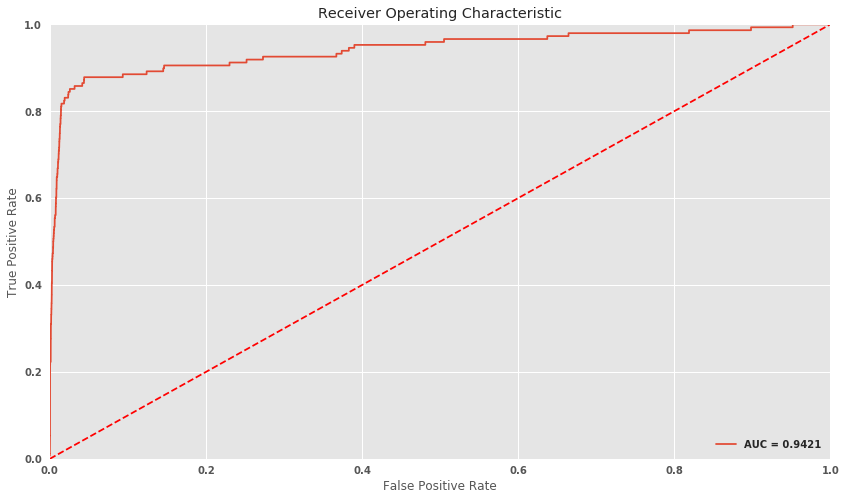

In [1364]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

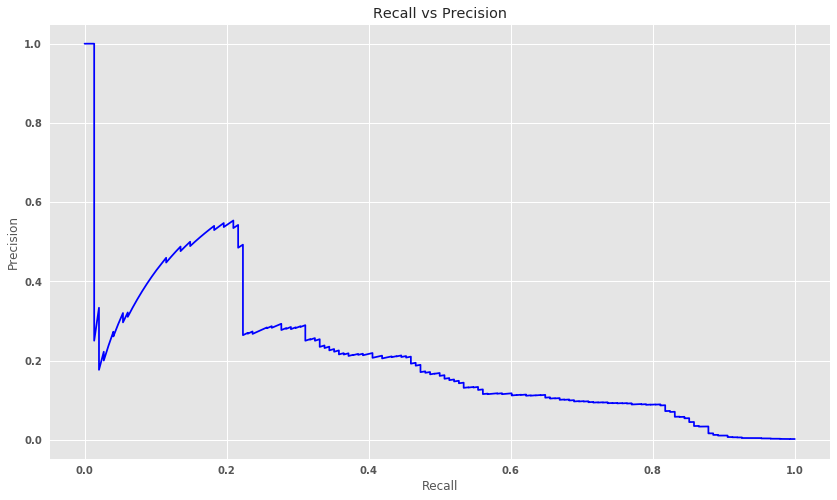

In [1365]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

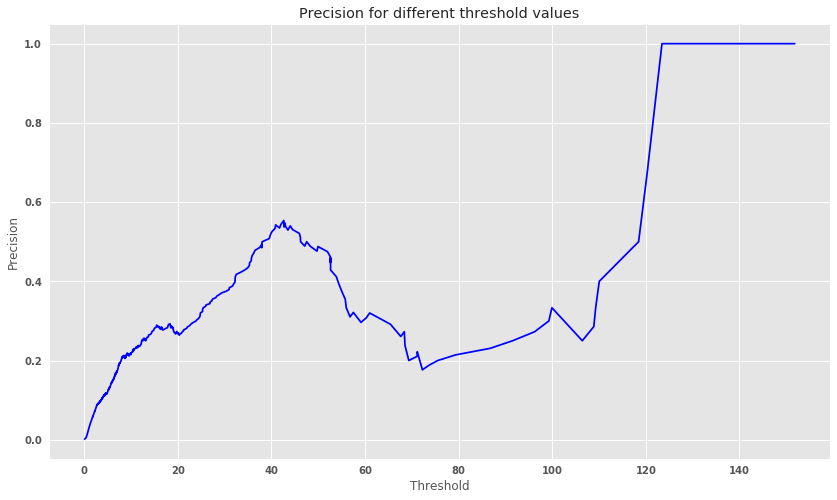

In [1366]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

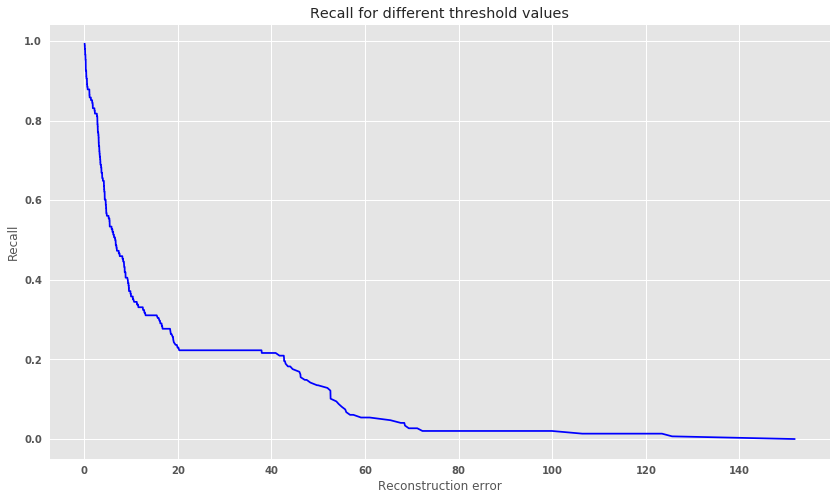

In [1367]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

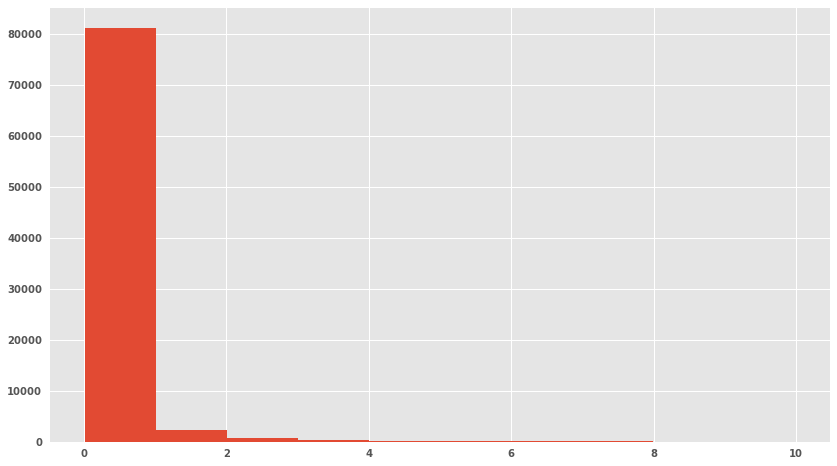

In [1368]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

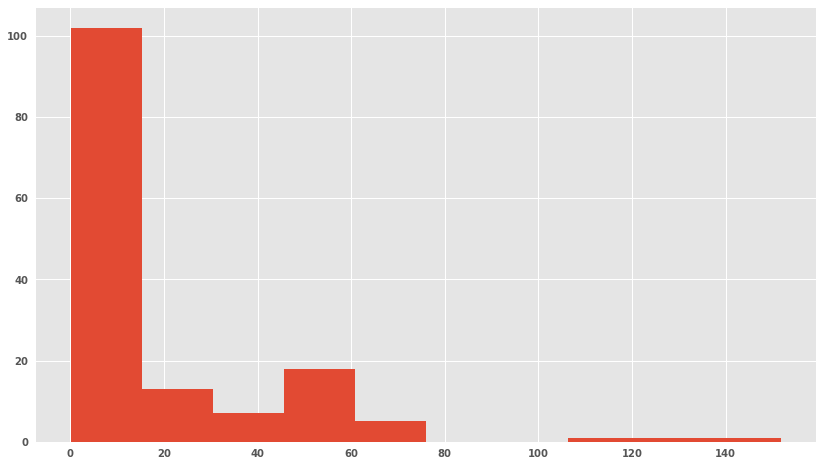

In [1369]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

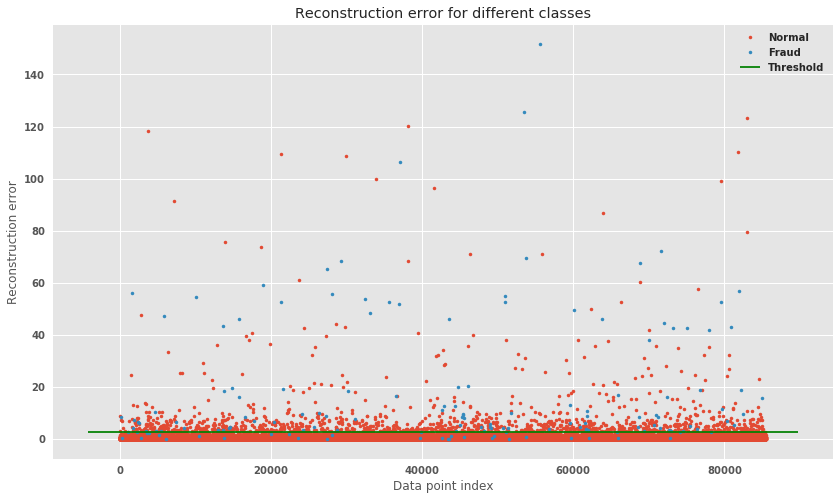

In [1388]:
threshold =2.6


groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error,marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="g", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

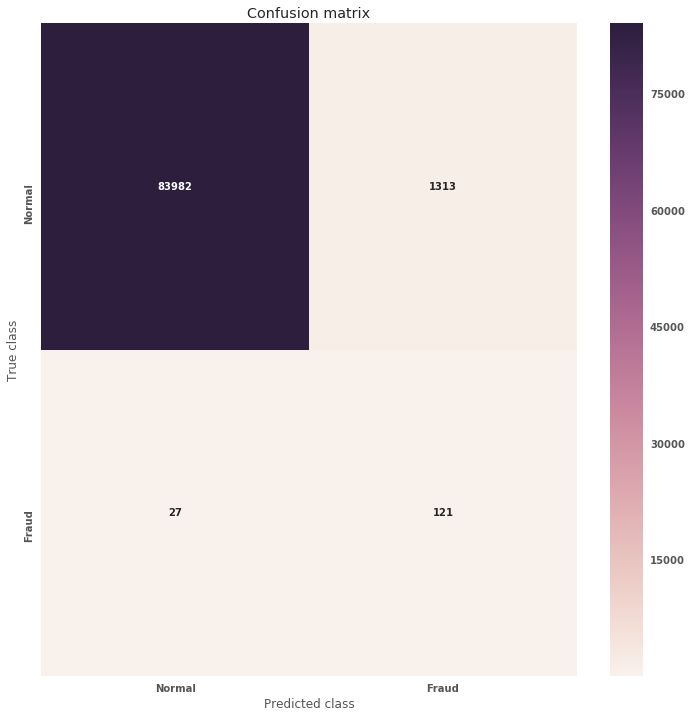

In [1389]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# using H2o

In [1397]:
X_train,Y_train,X_test,Y_test=feature_engineering(data)

In [1393]:
import h2o
h2o.init(max_mem_size=24)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_141"; Java(TM) SE Runtime Environment (build 1.8.0_141-b15); Java HotSpot(TM) 64-Bit Server VM (build 25.141-b15, mixed mode)
  Starting server from /home/namanda/anaconda3.6/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /home/namanda/tmp/tmp8xzlonx7
  JVM stdout: /home/namanda/tmp/tmp8xzlonx7/h2o_namanda_started_from_python.out
  JVM stderr: /home/namanda/tmp/tmp8xzlonx7/h2o_namanda_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.16.0.4
H2O cluster version age:,1 month and 19 days
H2O cluster name:,H2O_from_python_namanda_alp20s
H2O cluster total nodes:,1
H2O cluster free memory:,21.33 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [1399]:
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator

In [1401]:
train_frame.hex=h2o.H2OFrame(X_train)
test_frame.hex=h2o.H2OFrame(X_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [1402]:
model_nn=H2OAutoEncoderEstimator(activation="Tanh",
                              hidden=[14,7,14],
                              ignore_const_cols=False,
                              epochs=100,seed = 42)

In [1403]:
predictors=X_train.columns.tolist()

In [1406]:
model_nn.train(x=predictors,training_frame=train_frame.hex)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
